Library


In [1]:
import librosa
import numpy as np
import pandas as pd
from typing import Tuple
import joblib
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

Konstanta


In [2]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

dir_data_nad = MAIN_PATH+ r"\Dataset\noise-audio-data"

# Pra-Pemrosesan


Function


In [3]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

Function Utama


In [4]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

# Ekstraksi Fitur


Function


In [5]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_spectral_flatness(segment):
    return np.mean(librosa.feature.spectral_flatness(y=segment))

# Fitting


Load Scaler


In [6]:
scl = joblib.load(f"{MAIN_PATH}/Model/p_scaler.pkl")

Squeze


In [7]:
def normalisasi(rms, zcr):
    arr = np.array([[rms, zcr]])
    rms_zcr_scaled = scl.transform(arr)[0]
    return rms_zcr_scaled[0], rms_zcr_scaled[1]

# Visualize


Function


In [8]:
def load_and_plot(path, list_result, final_time):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title(f"Audio waveform with loud segments marked - {file_name}") 
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    for i in enumerate(list_result):
        start_time = i[1][0]
        end_time = i[1][1]
        plt.axvspan(start_time, end_time, color='red', alpha=0.3)

    plt.xticks(np.arange(0, final_time, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, final_time)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

# Model


Load


In [9]:
model = joblib.load(f"{MAIN_PATH}/Model/p_lgbm.pkl")

# Main Process


In [10]:
def main_pipeline(path):
    result = []

    segments = prapemrosesan(path)
    for i, segment in enumerate(segments):
        start_time = round(i * 0.5, 2)
        end_time = round(start_time + 1.0, 2)
        timestamp = [start_time, end_time]

        rms = get_rms(segment)
        flatness = get_spectral_flatness(segment)
        rms, flatness = normalisasi(rms, flatness)
        label = model.predict([[rms, flatness]])[0]

        result.append({
            "name": path.split("/")[-1],
            "timestamp": timestamp,
            "label": label
        })

    return result

Contoh 1


In [11]:
audio_1 = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data\1-137-A-32.wav"
result_1 = main_pipeline(audio_1)

list_label_1 = [data["timestamp"] for data in result_1 if data["label"] == 1]
list_label_1

[]

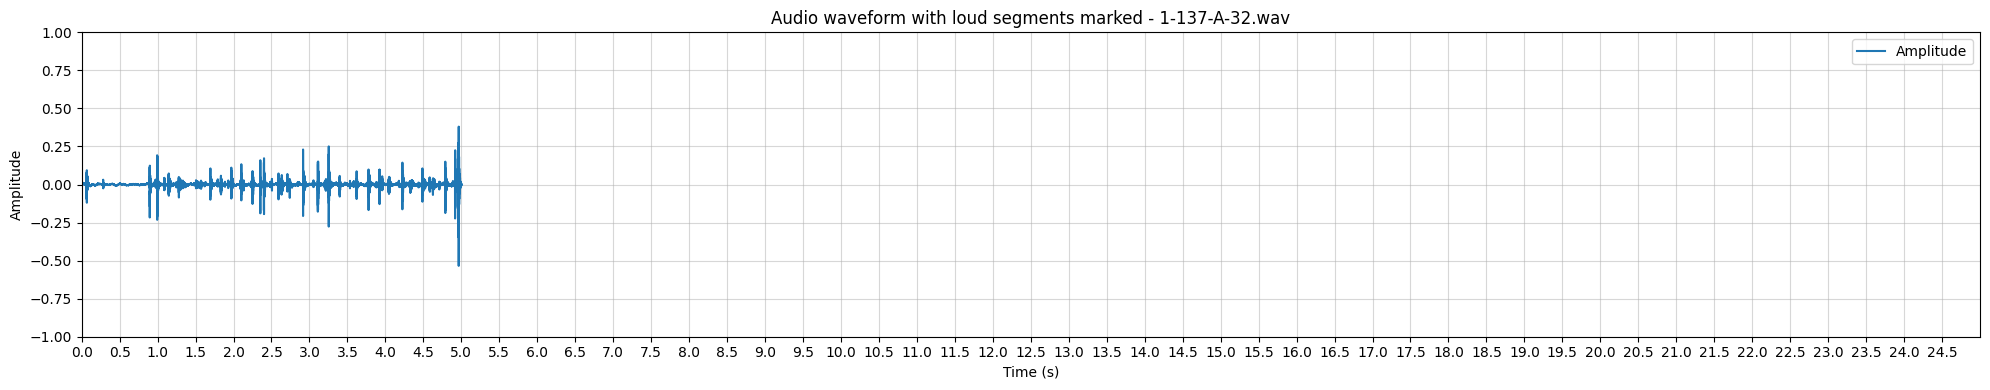

In [12]:
load_and_plot(audio_1, list_label_1, 25)

Loop


1-100032-A-0.wav, [[1.5, 2.5], [2.0, 3.0]]


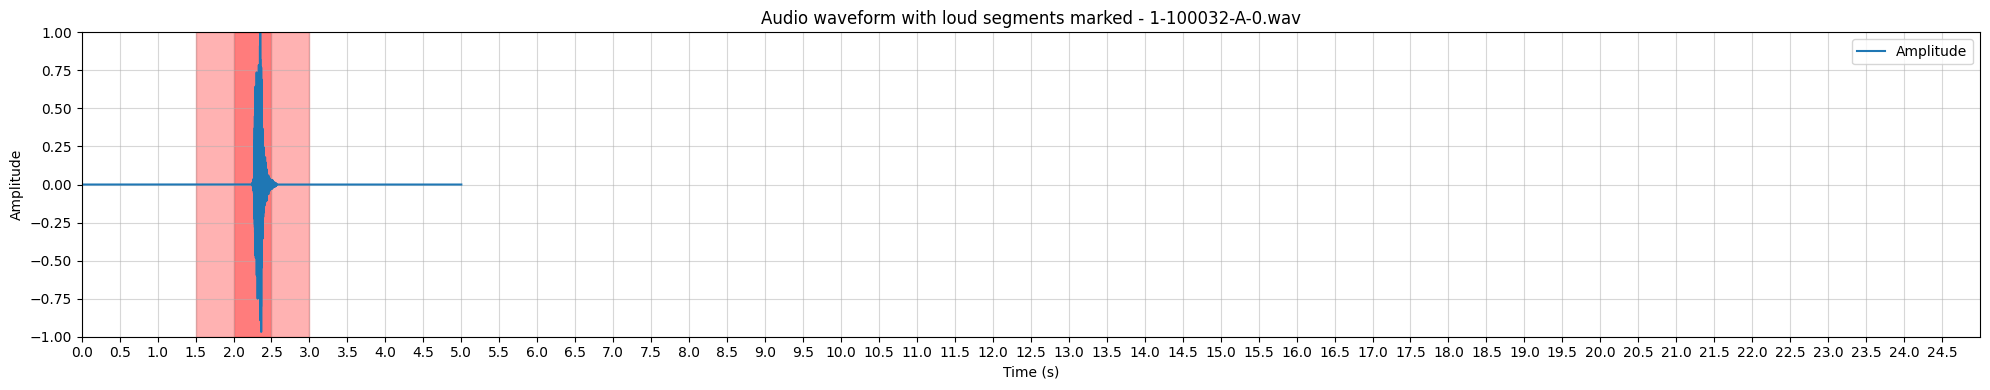

1-100038-A-14.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


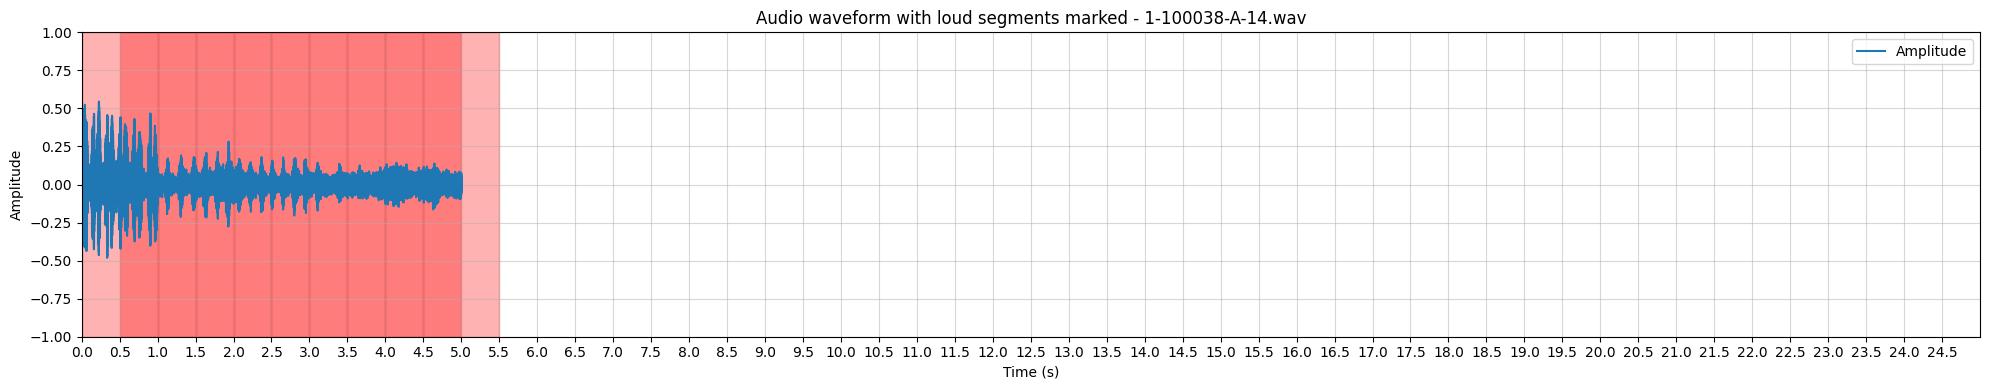

1-100210-A-36.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


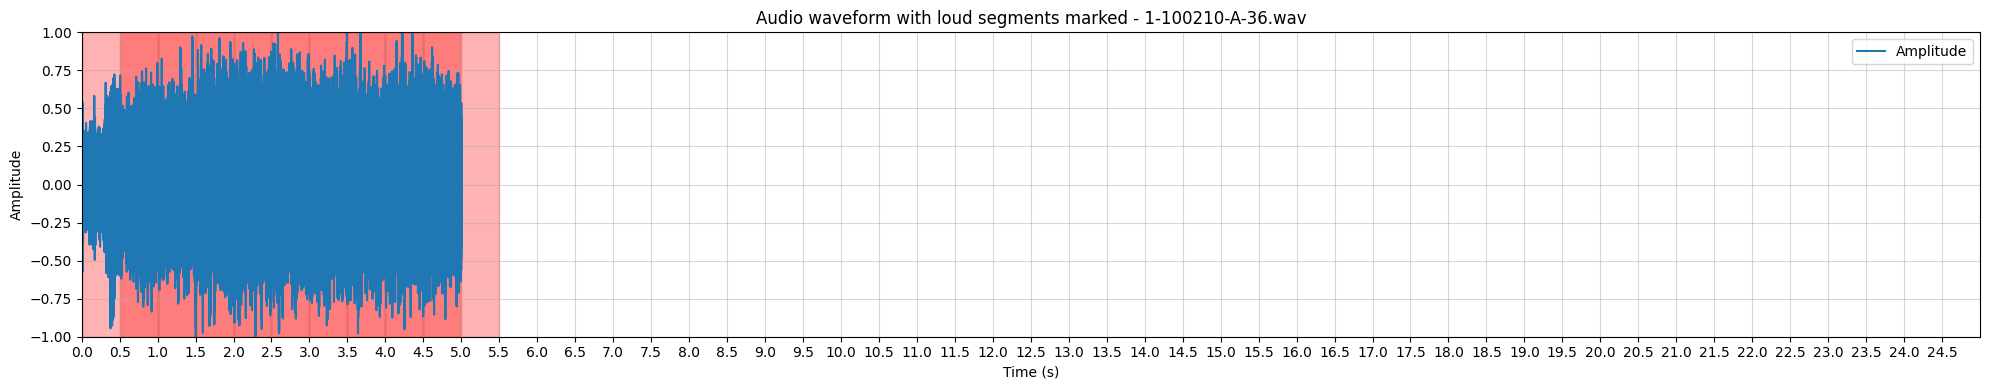

1-100210-B-36.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


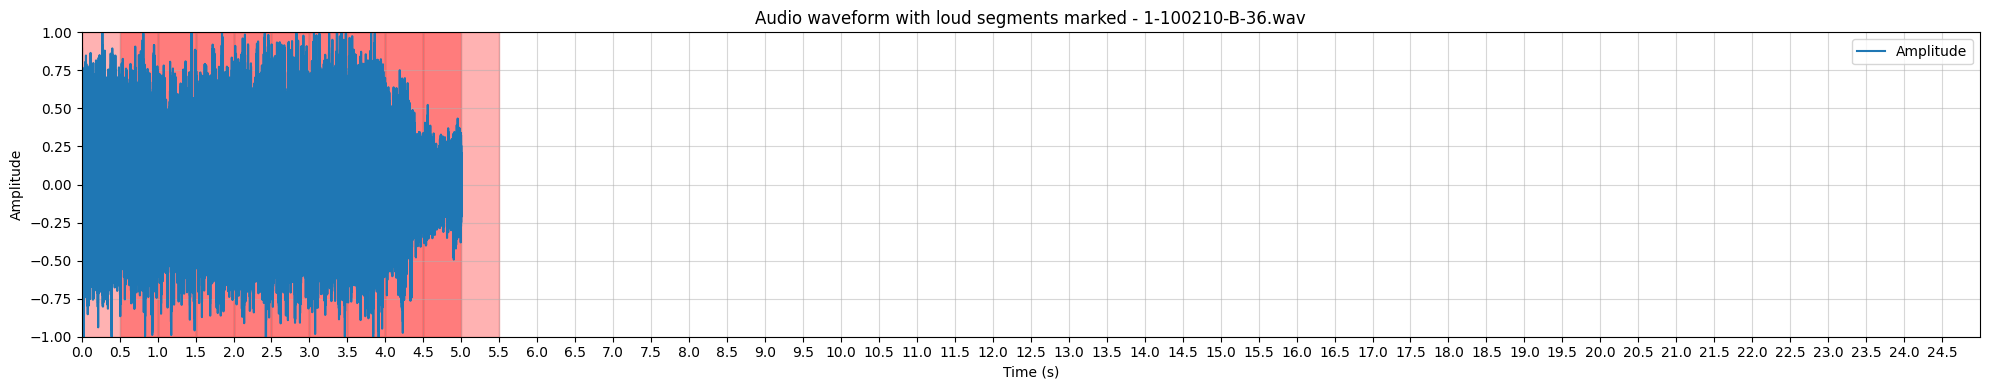

1-101296-A-19.wav, [[0.5, 1.5], [1.0, 2.0], [3.5, 4.5]]


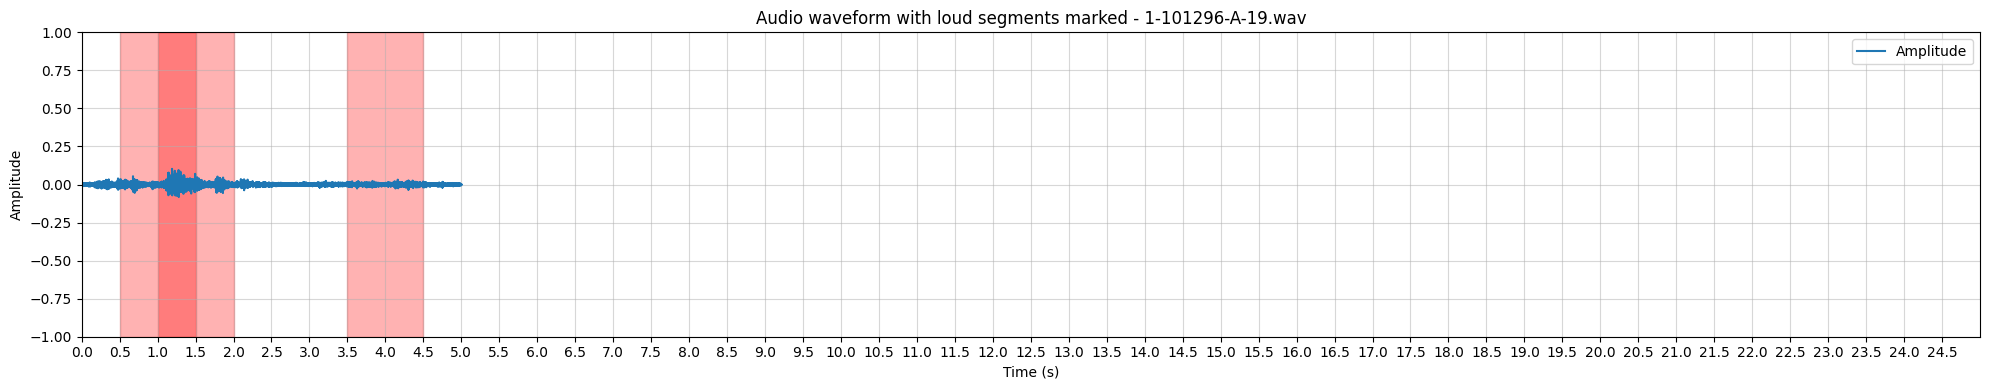

1-101296-B-19.wav, [[1.0, 2.0], [1.5, 2.5]]


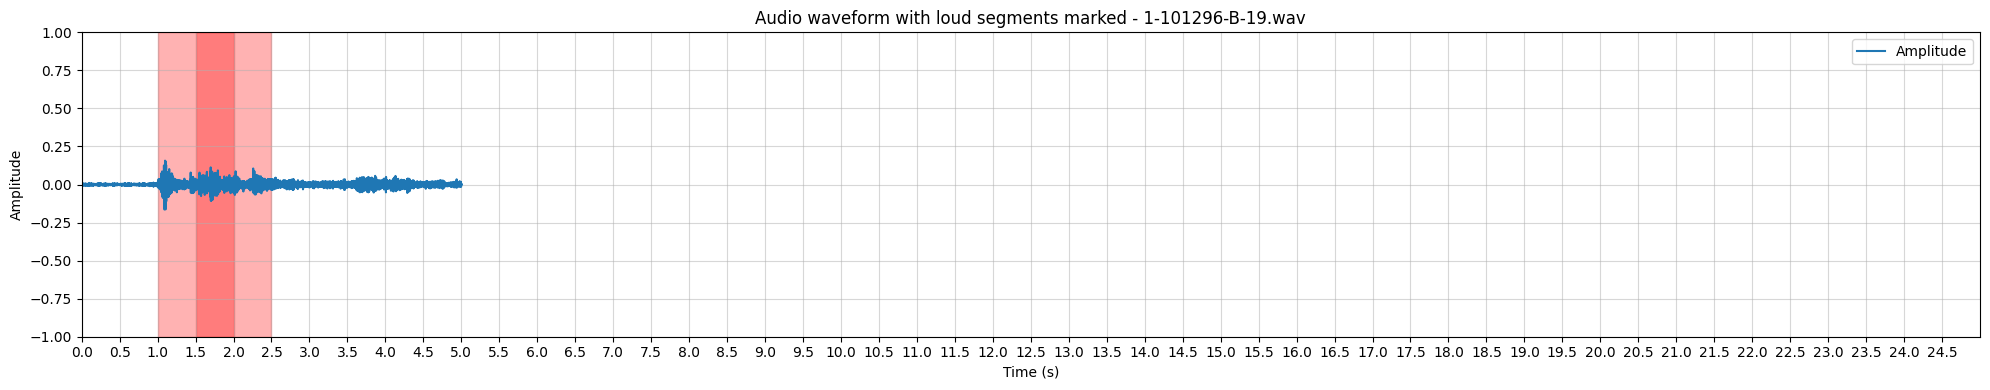

1-101336-A-30.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5]]


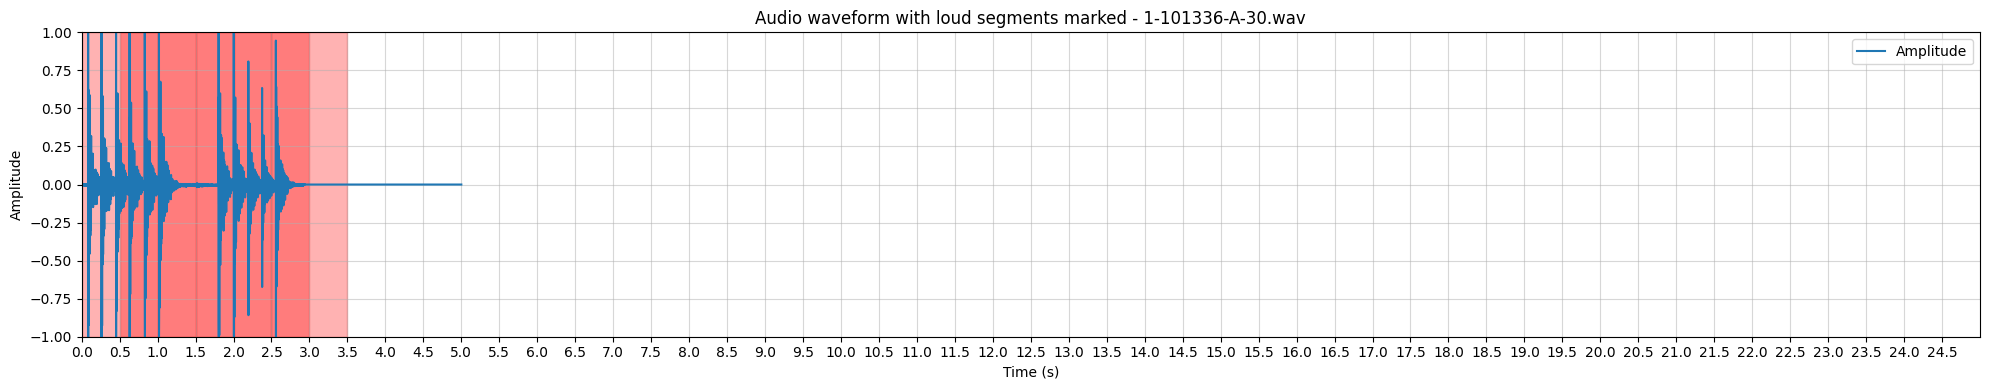

1-101404-A-34.wav, [[0.0, 1.0], [0.5, 1.5]]


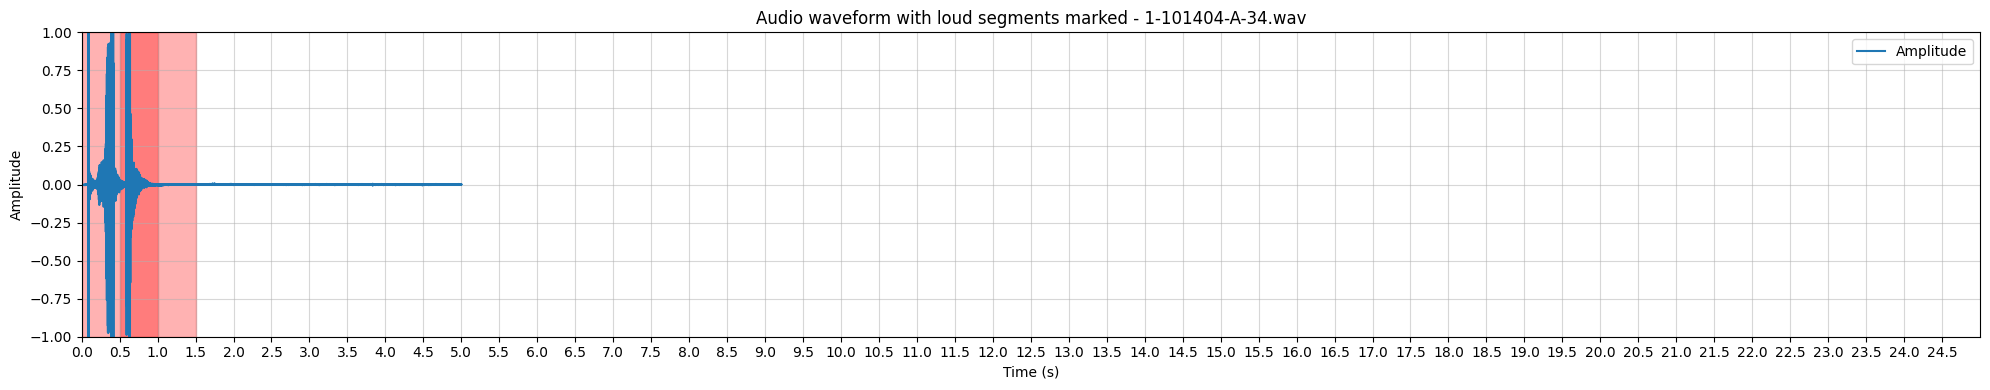

1-103298-A-9.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


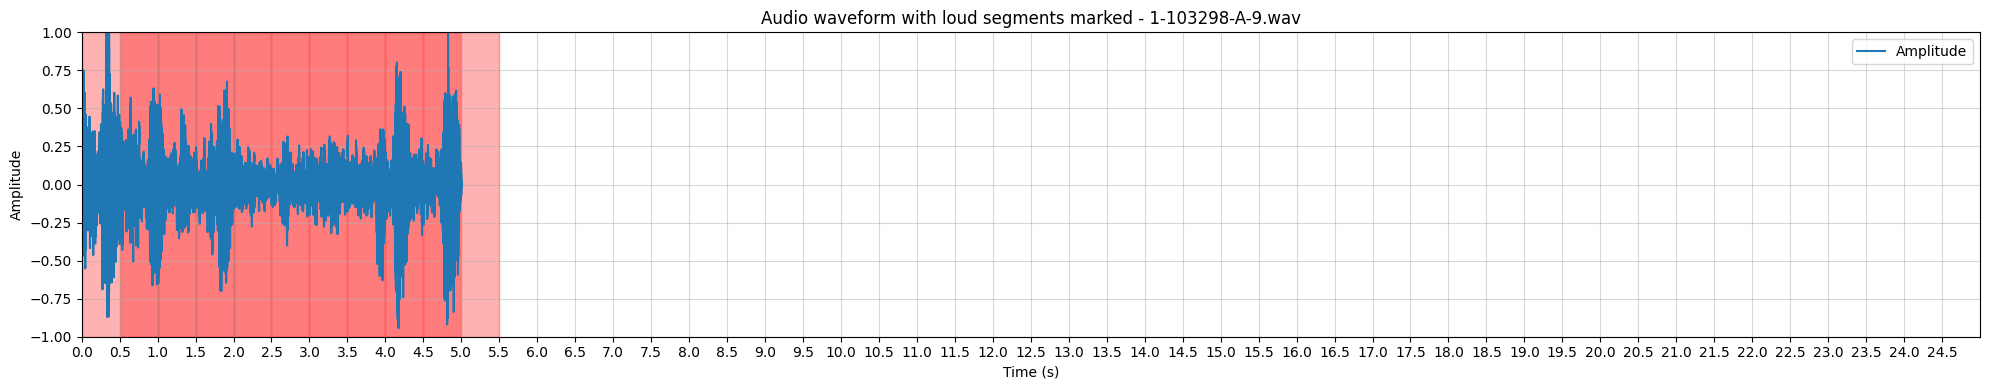

1-103995-A-30.wav, [[0.0, 1.0], [0.5, 1.5]]


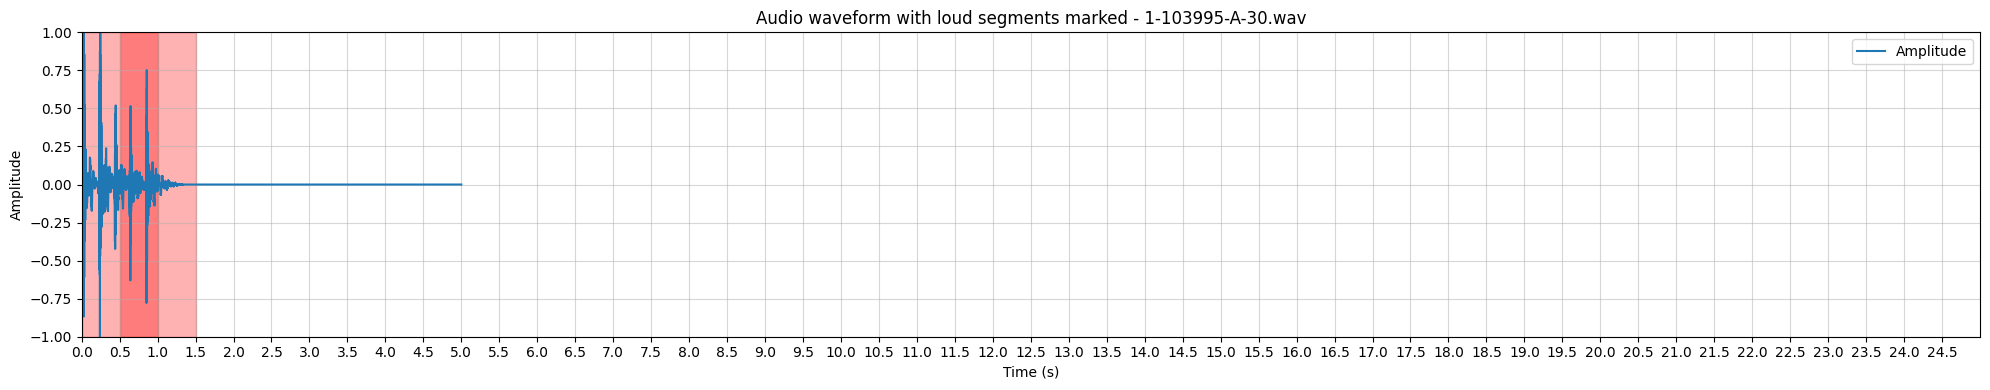

1-103999-A-30.wav, [[0.0, 1.0], [0.5, 1.5]]


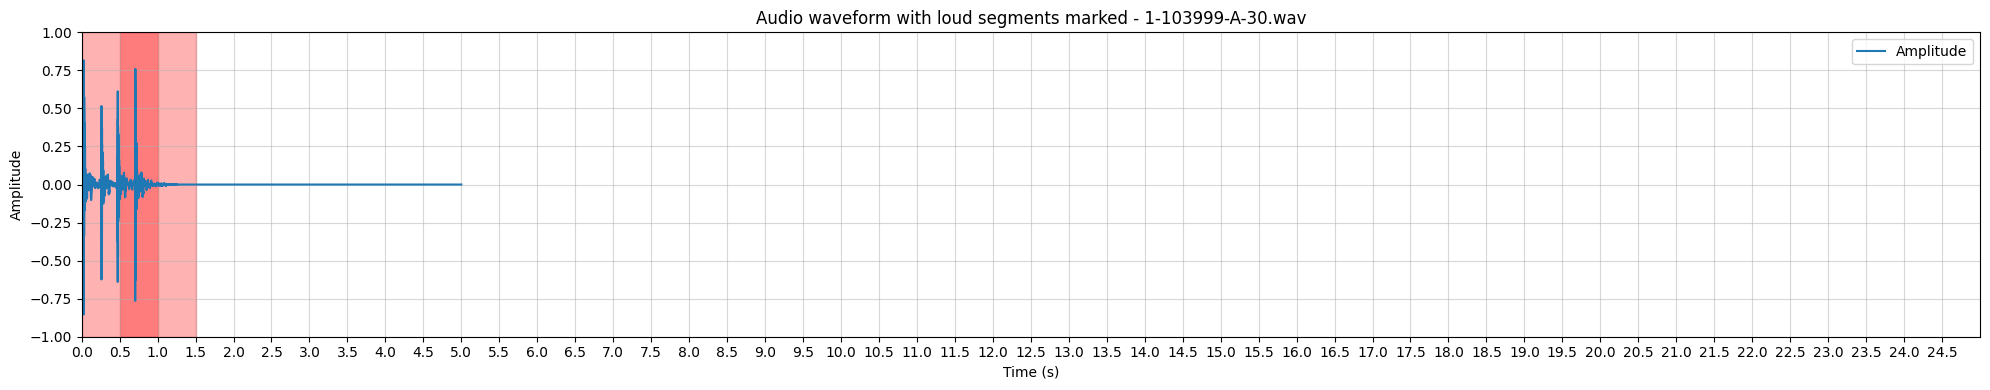

1-104089-A-22.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


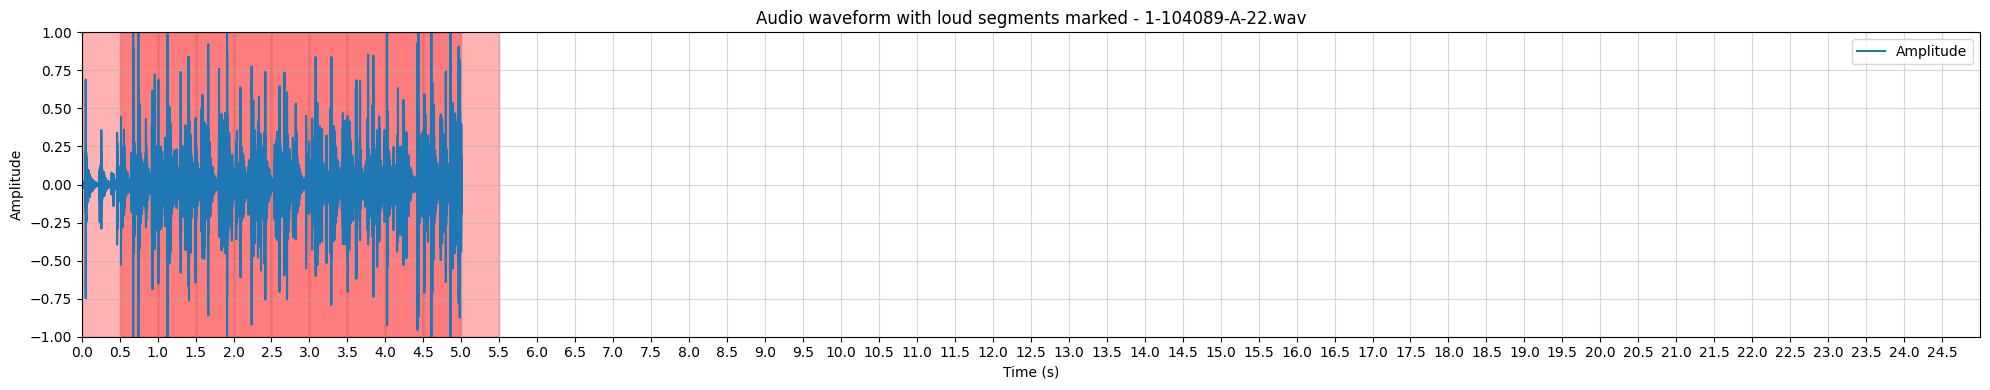

1-104089-B-22.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


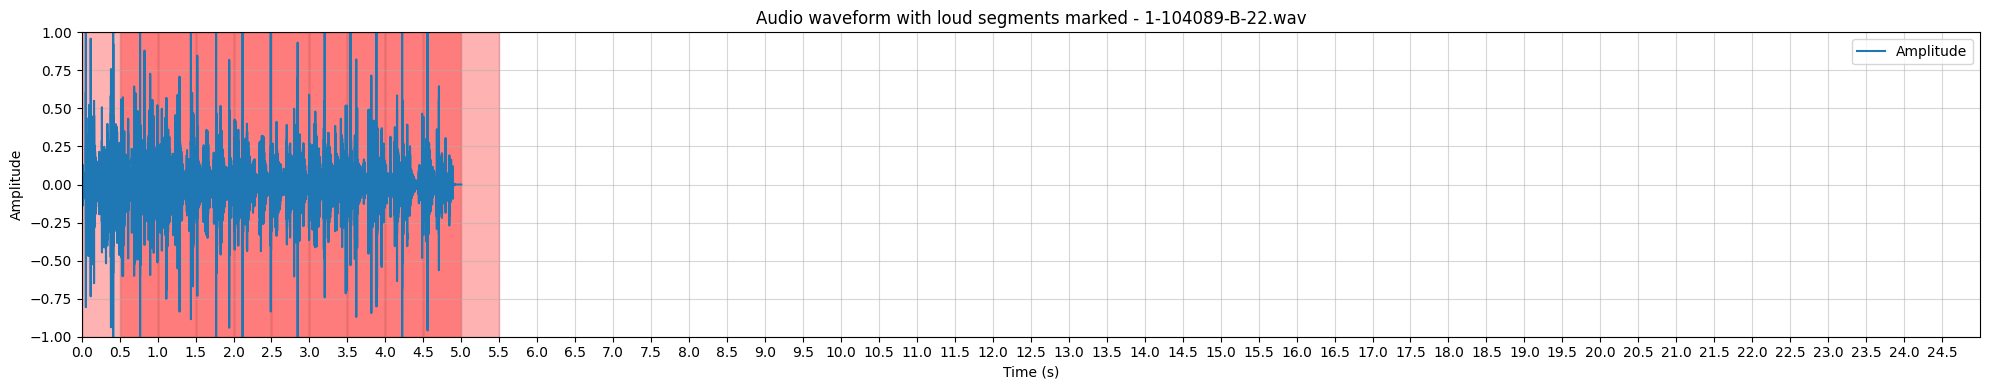

1-105224-A-22.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


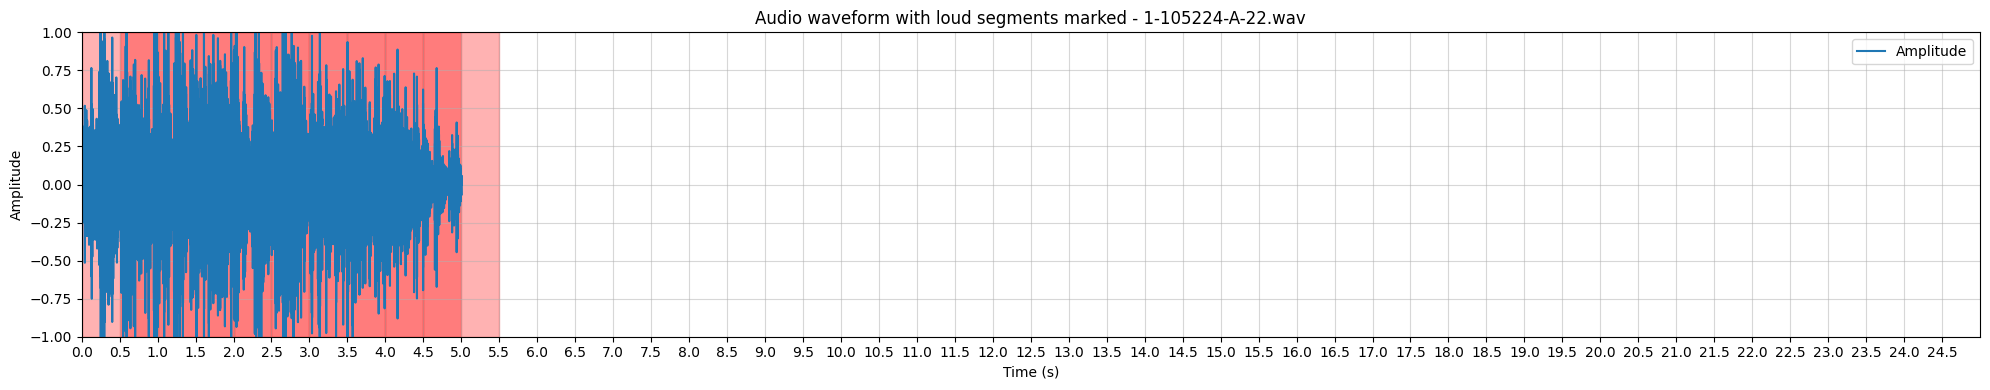

1-110389-A-0.wav, [[0.0, 1.0]]


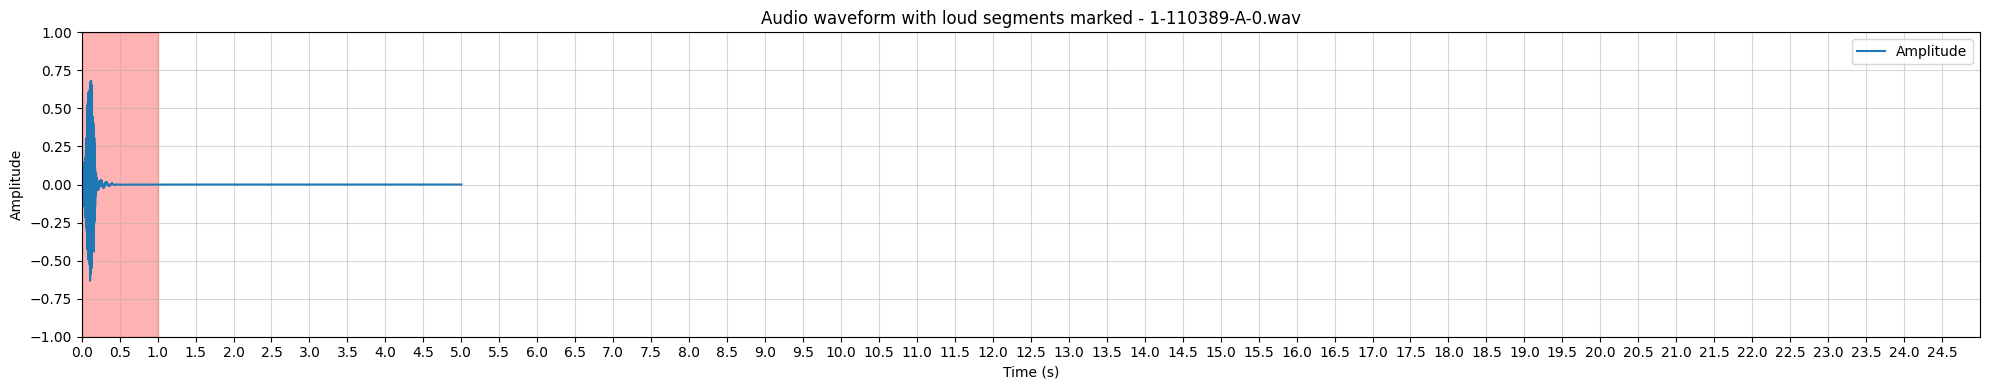

1-110537-A-22.wav, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5]]


KeyboardInterrupt: 

In [13]:
folder = f"{MAIN_PATH}/Dataset/noise-audio-data"
for file in os.listdir(folder):
    path = f"{folder}/{file}"
    result = main_pipeline(path)
    list_label = [data["timestamp"] for data in result if data["label"] == 1]
    print(f"{file}, {list_label}")
    load_and_plot(path, list_label, 25)

151761.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0]]


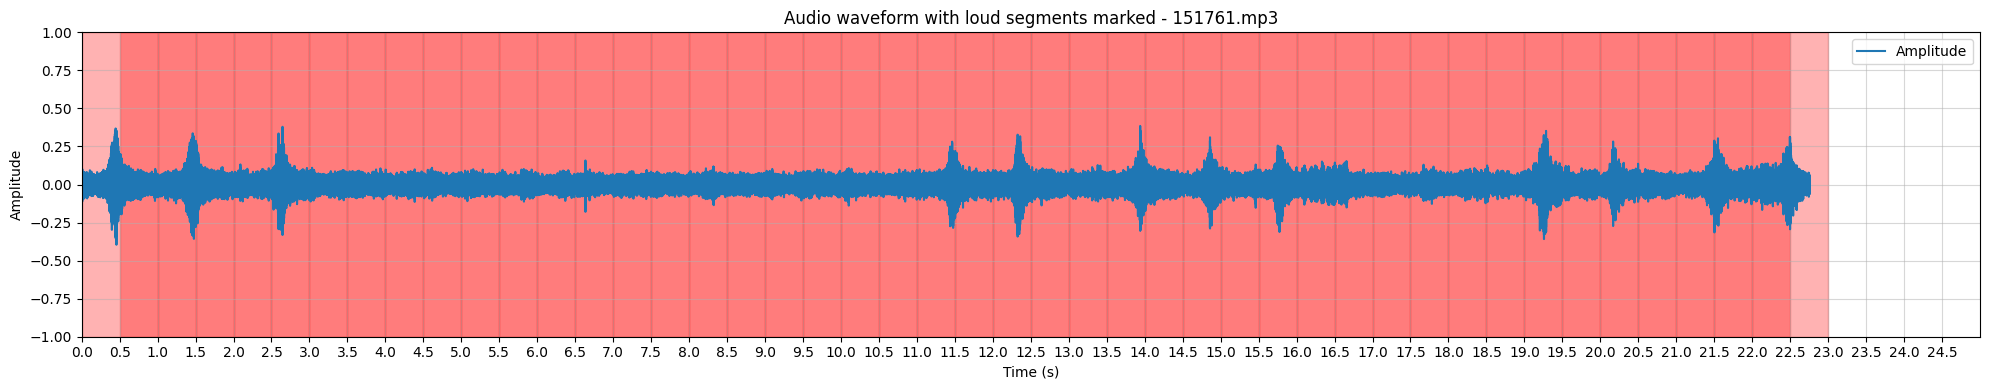

169538.mp3, [[1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0]]


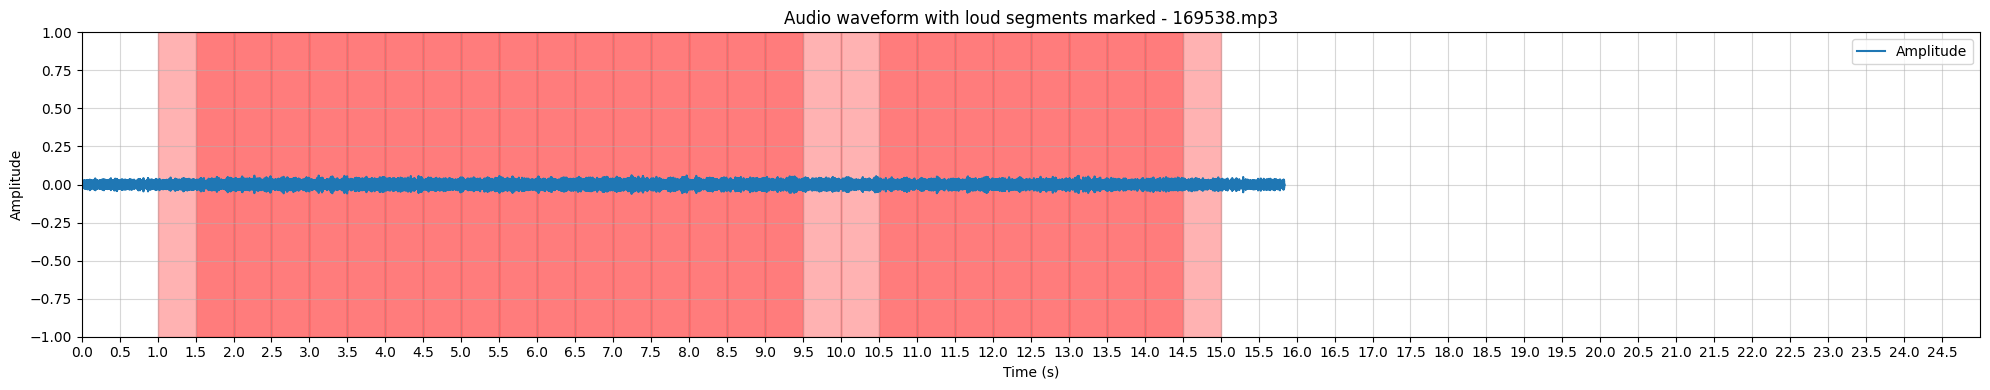

193835.mp3, [[1.5, 2.5], [3.0, 4.0], [4.5, 5.5], [5.0, 6.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [18.0, 19.0], [19.5, 20.5], [21.0, 22.0]]


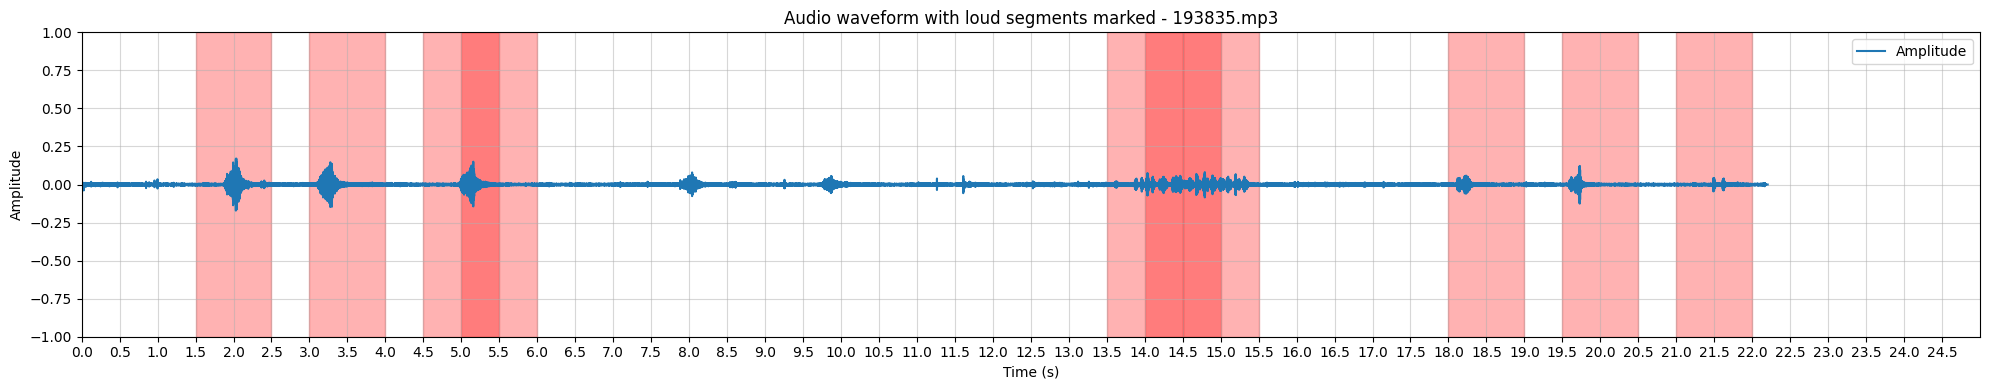

19655.mp3, [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0]]


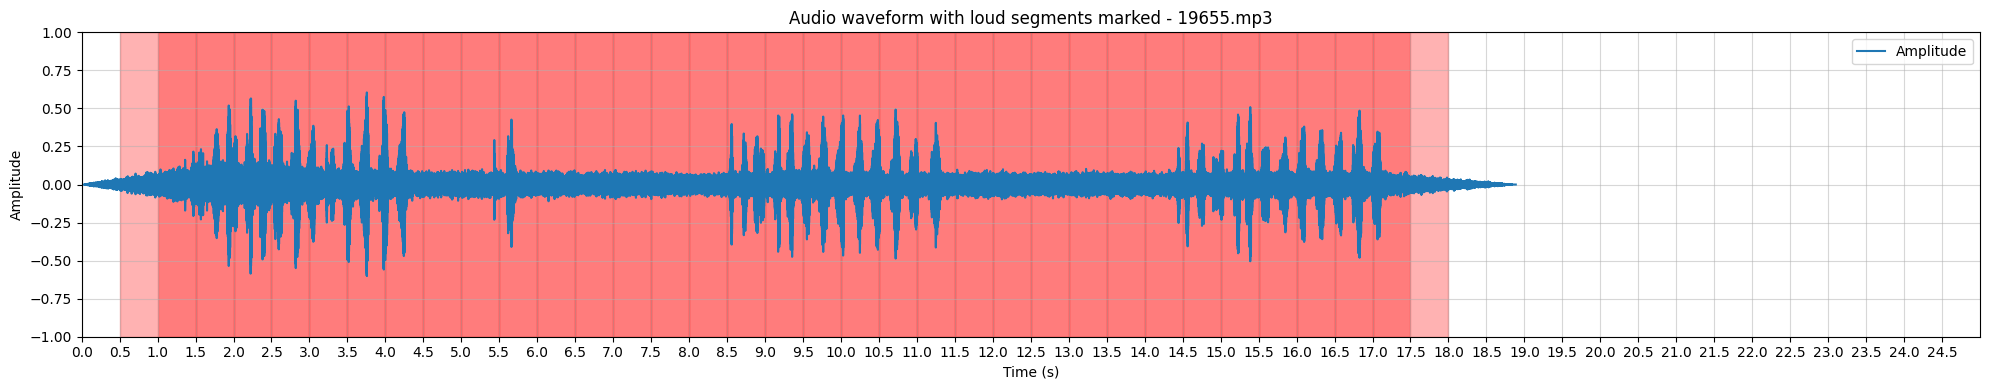

198426.mp3, [[0.5, 1.5], [1.5, 2.5], [2.0, 3.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [11.0, 12.0], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0]]


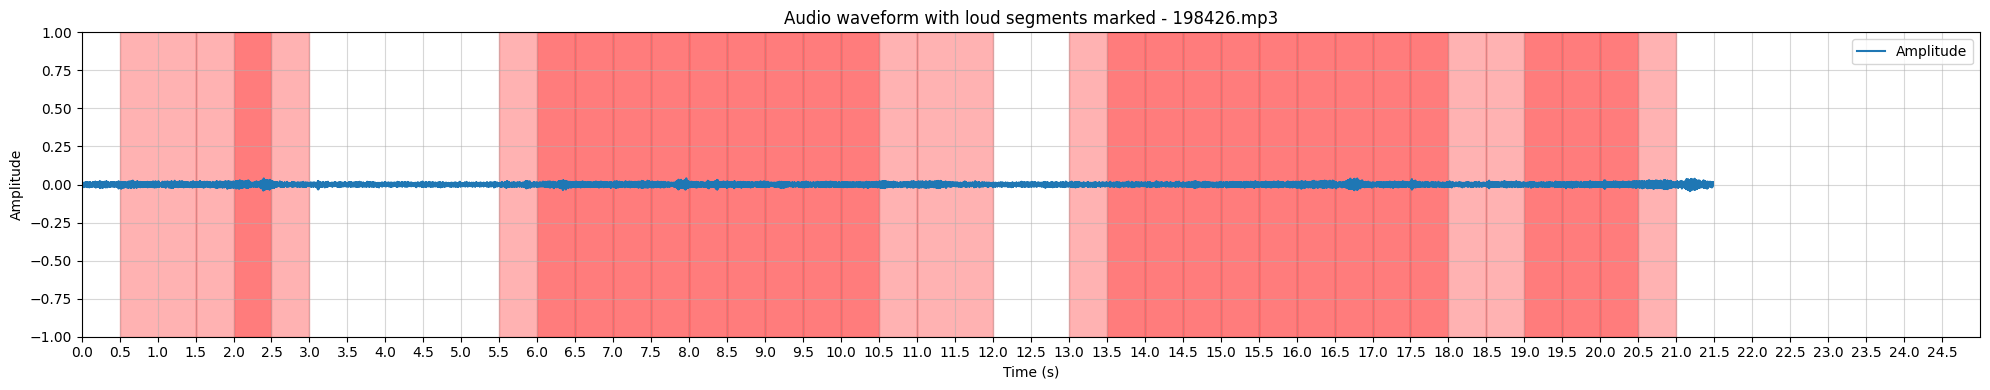

204334.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0]]


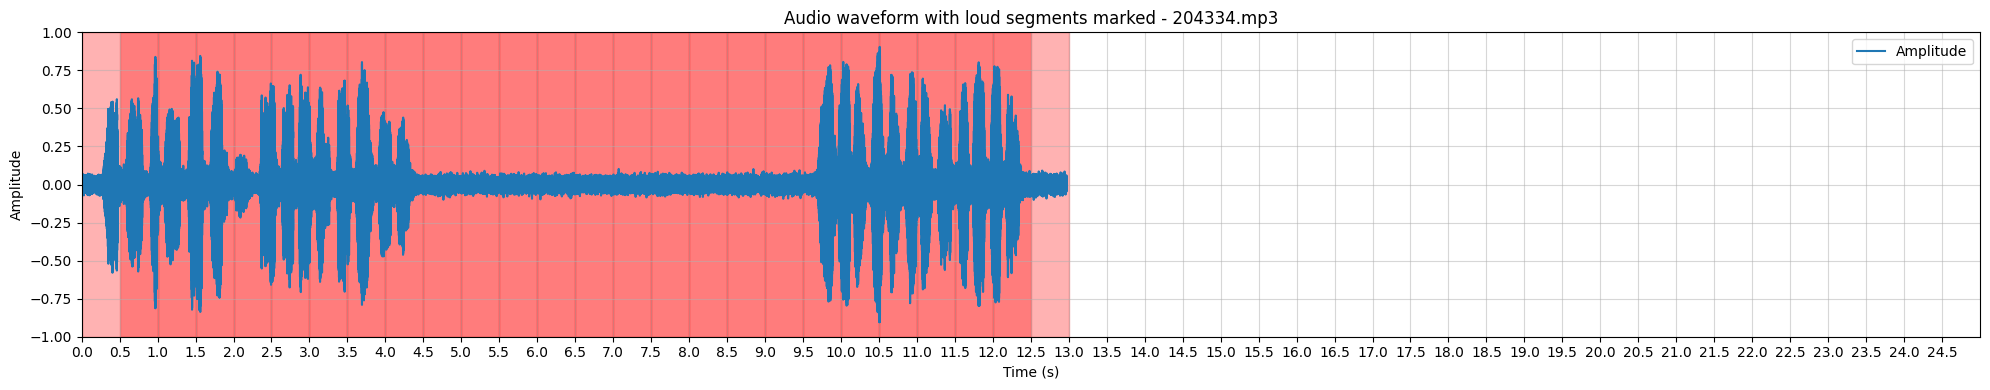

215401.mp3, [[0.0, 1.0], [1.0, 2.0], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5]]


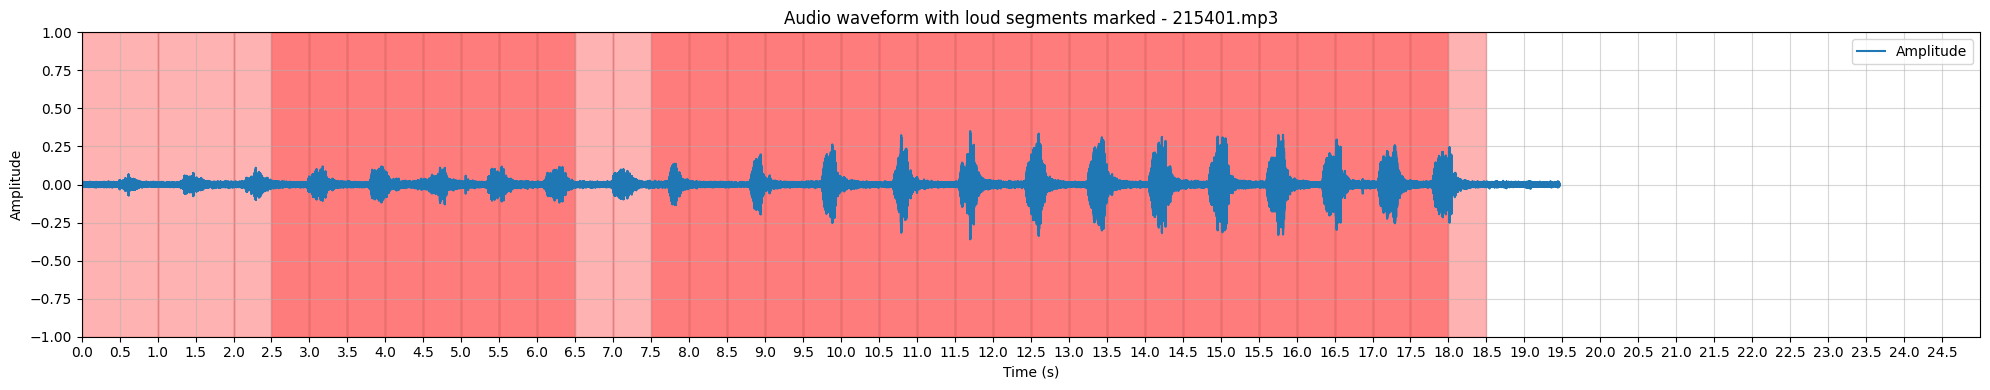

279210.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0]]


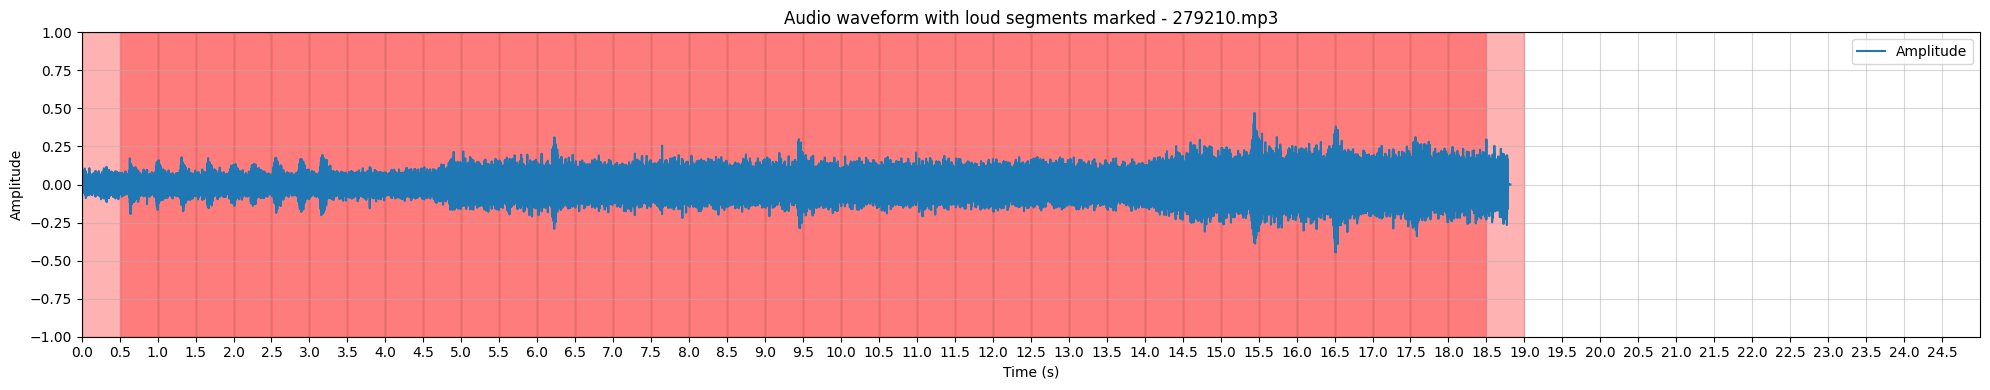

282469.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [4.5, 5.5], [5.5, 6.5], [6.0, 7.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5]]


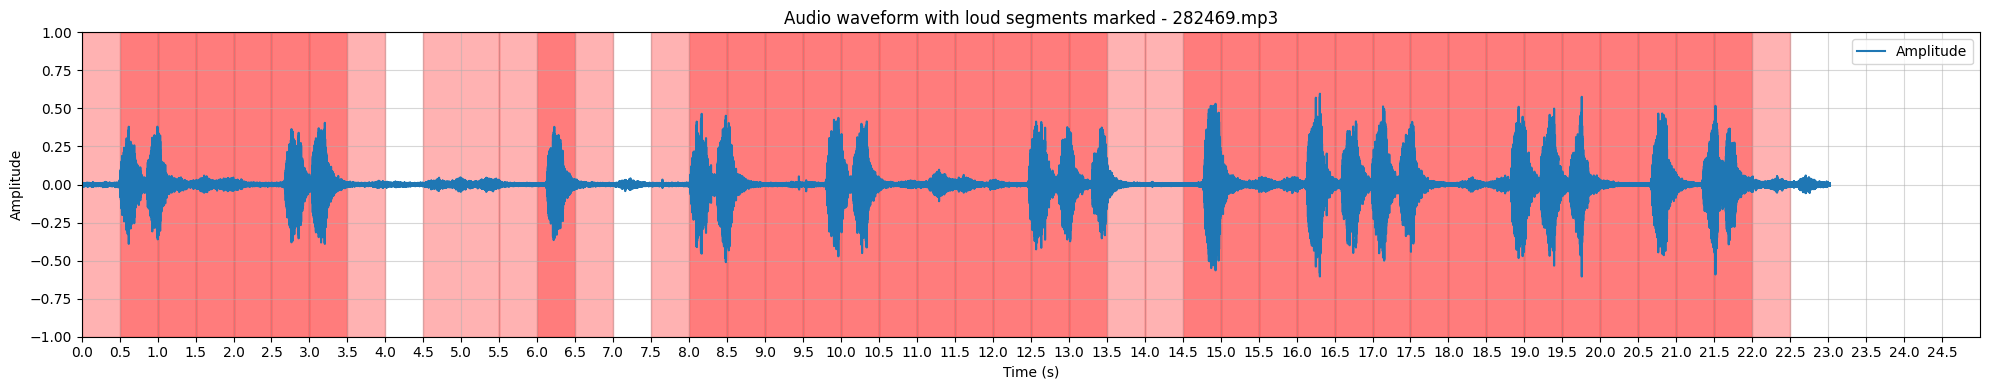

282506.mp3, [[0.0, 1.0], [0.5, 1.5], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5]]


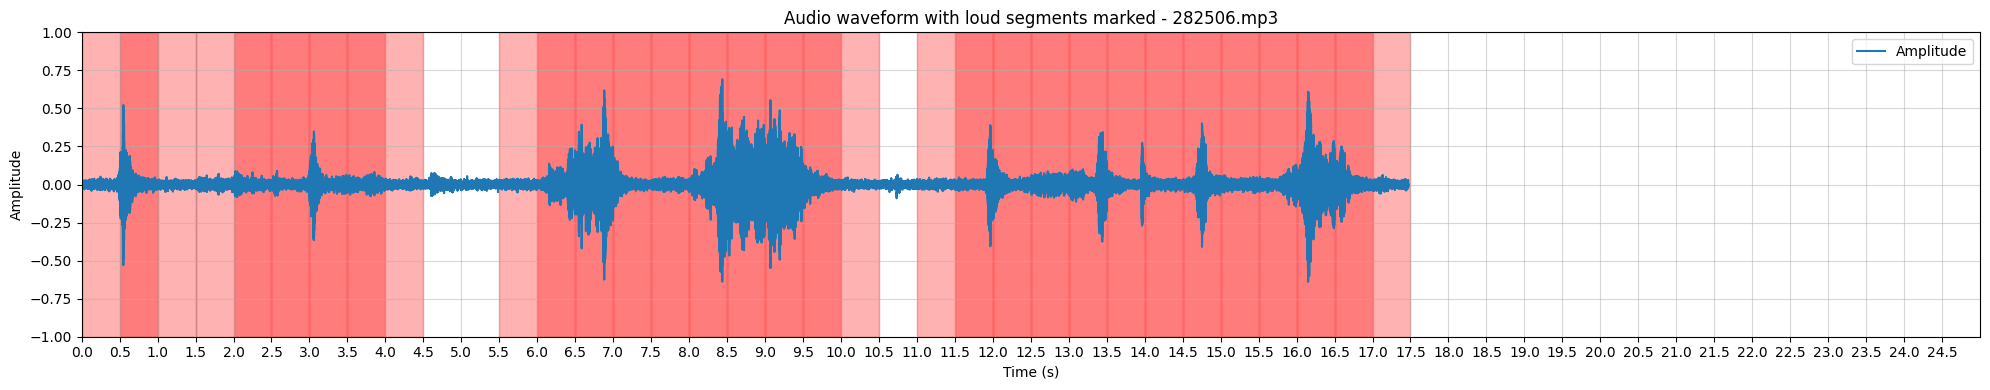

359523.mp3, [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [15.0, 16.0]]


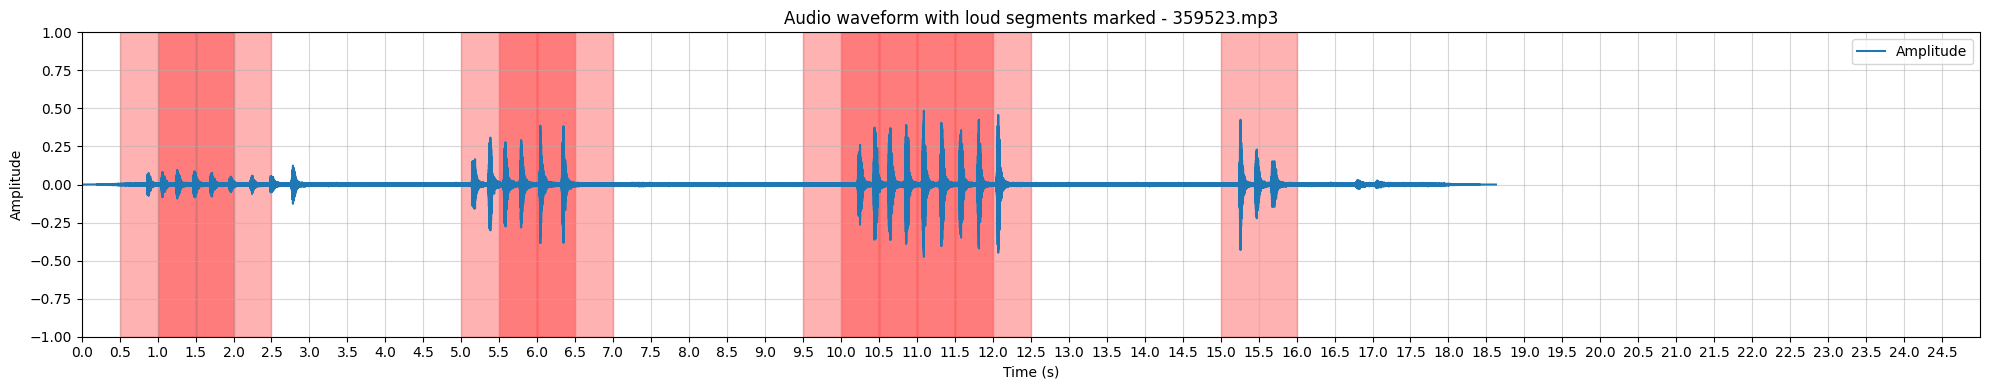

359552.mp3, [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [4.0, 5.0], [4.5, 5.5], [6.0, 7.0], [6.5, 7.5], [8.5, 9.5], [9.0, 10.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5]]


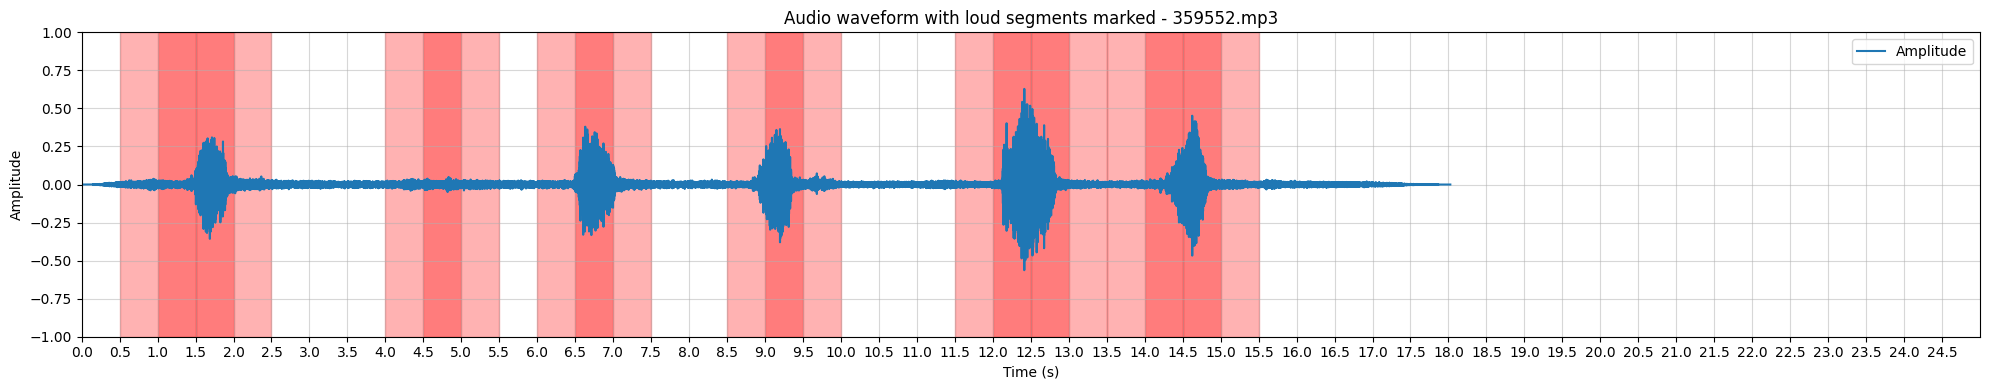

359595.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0], [22.5, 23.5], [23.0, 24.0], [23.5, 24.5], [24.0, 25.0], [24.5, 25.5], [25.5, 26.5], [26.0, 27.0], [26.5, 27.5], [27.0, 28.0], [28.0, 29.0], [28.5, 29.5], [29.0, 30.0], [29.5, 30.5], [30.0, 31.0], [30.5, 31.5], [31.0, 32.0], [31.5, 32.5], [32.0, 33.0], [32.5, 33.5]]


C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


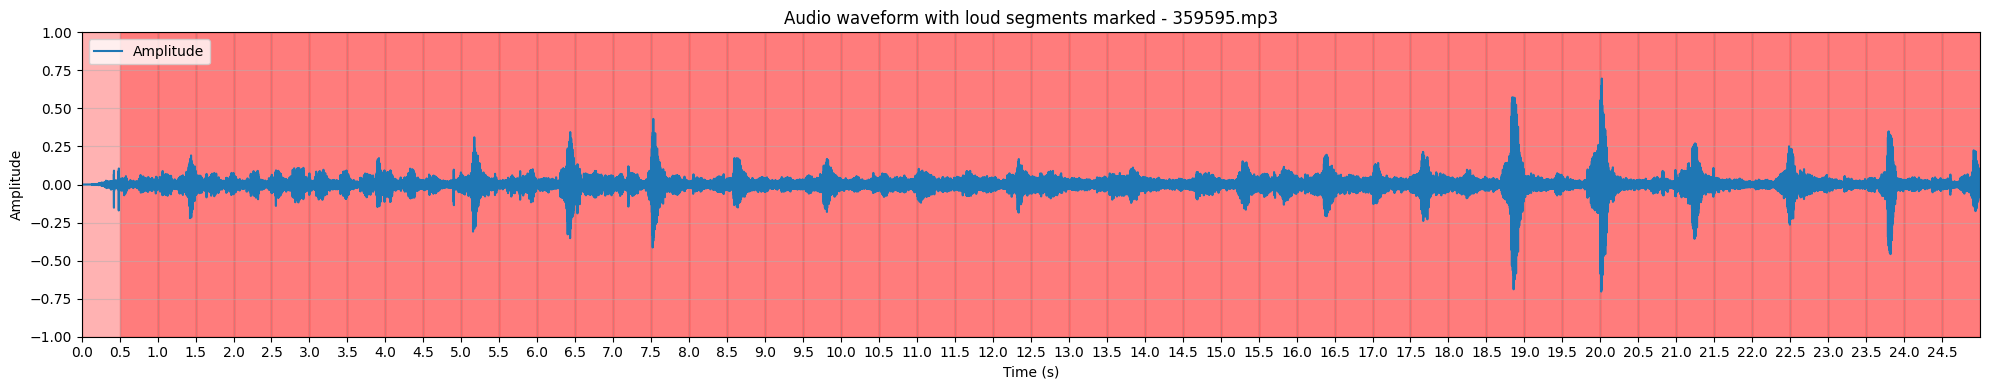

377589.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0], [22.5, 23.5], [23.0, 24.0]]


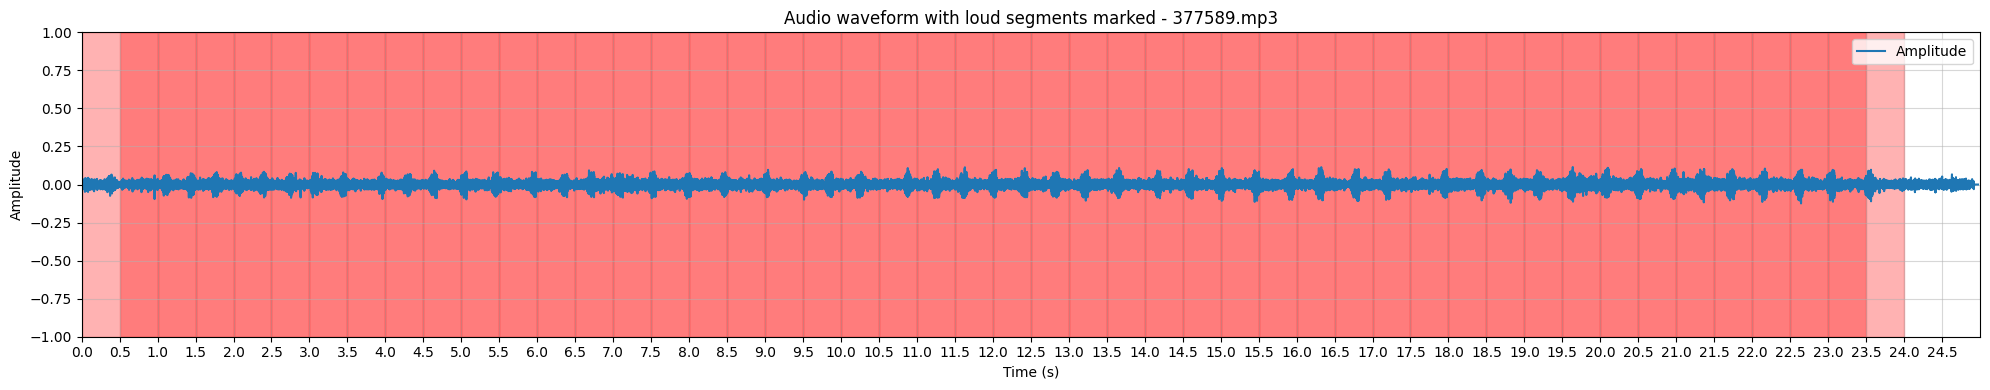

435909.mp3, [[0.5, 1.5], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5]]


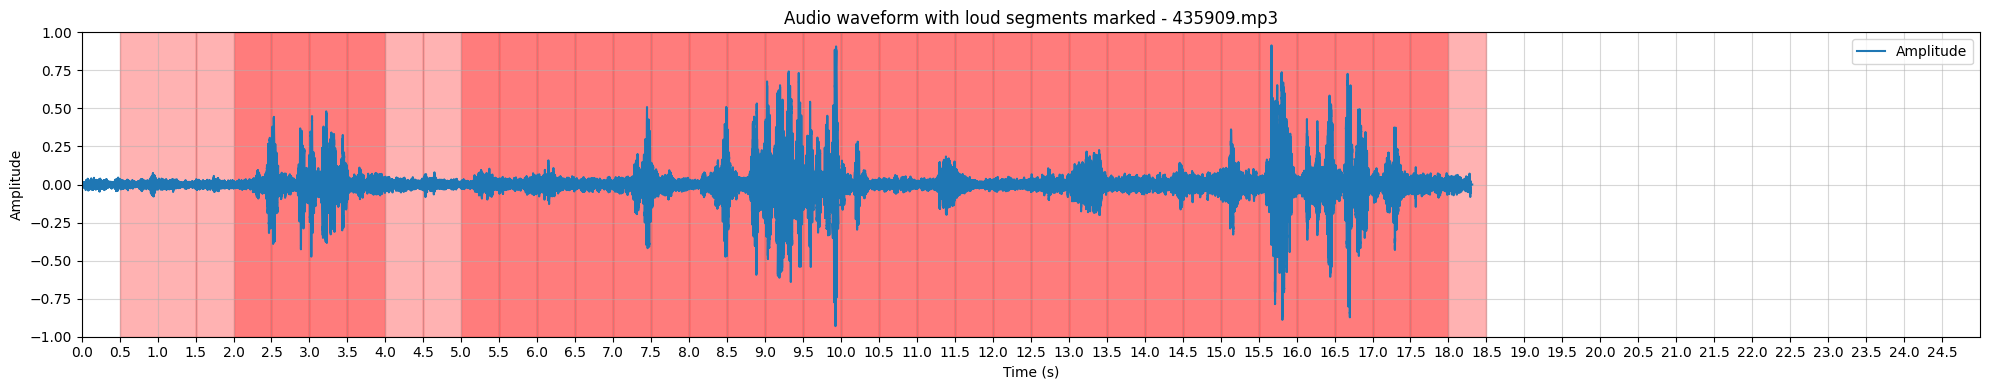

457336.mp3, [[5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0]]


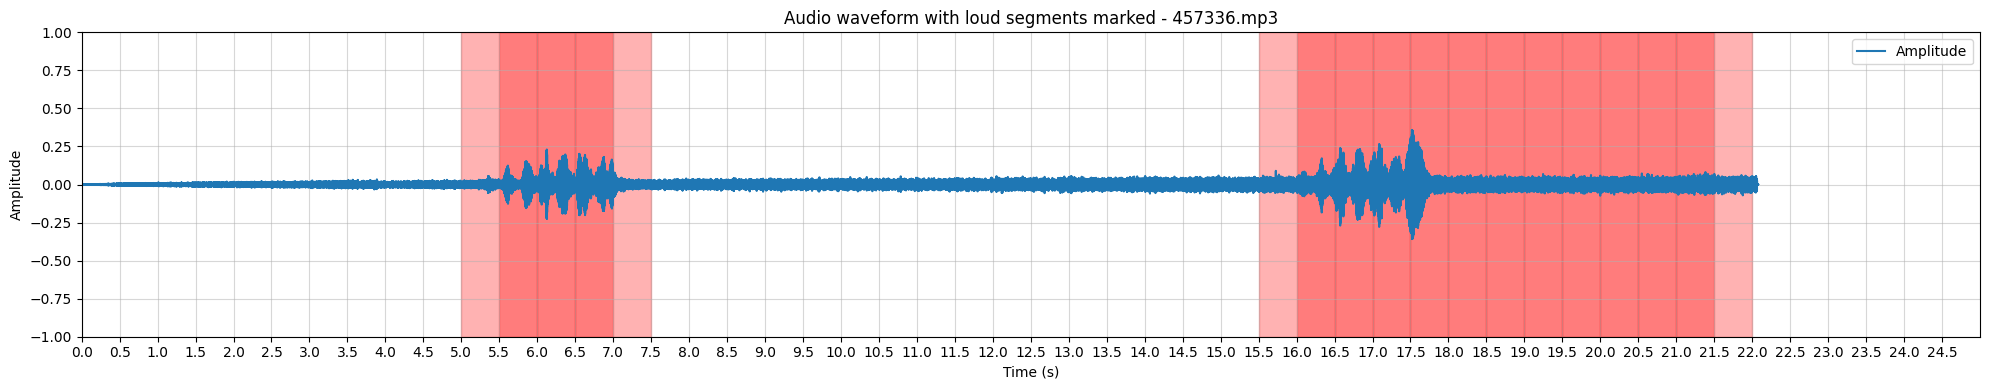

498380.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5]]


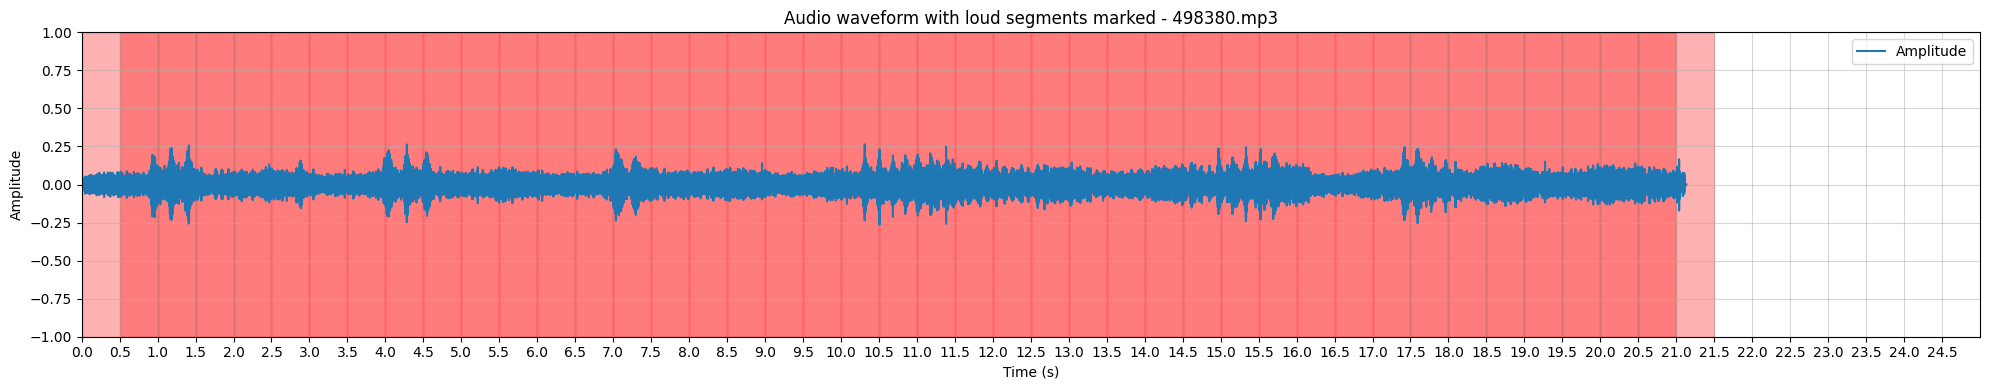

505545.mp3, [[0.0, 1.0], [2.5, 3.5], [3.0, 4.0], [4.0, 5.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [22.0, 23.0], [22.5, 23.5]]


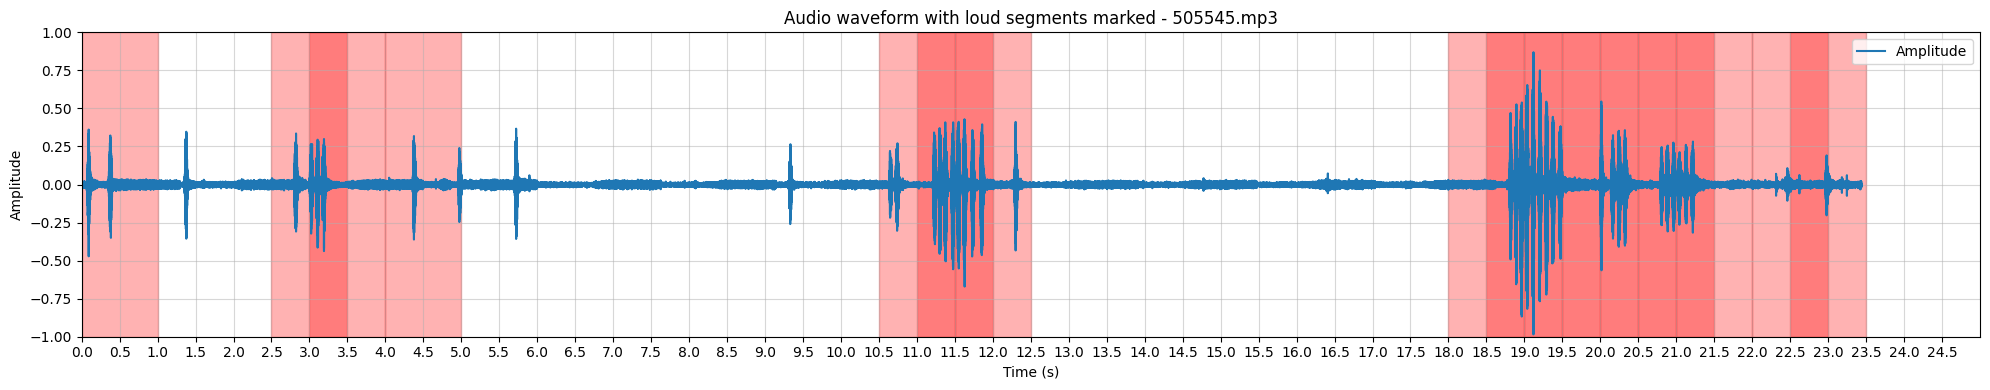

531042.mp3, [[1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5]]


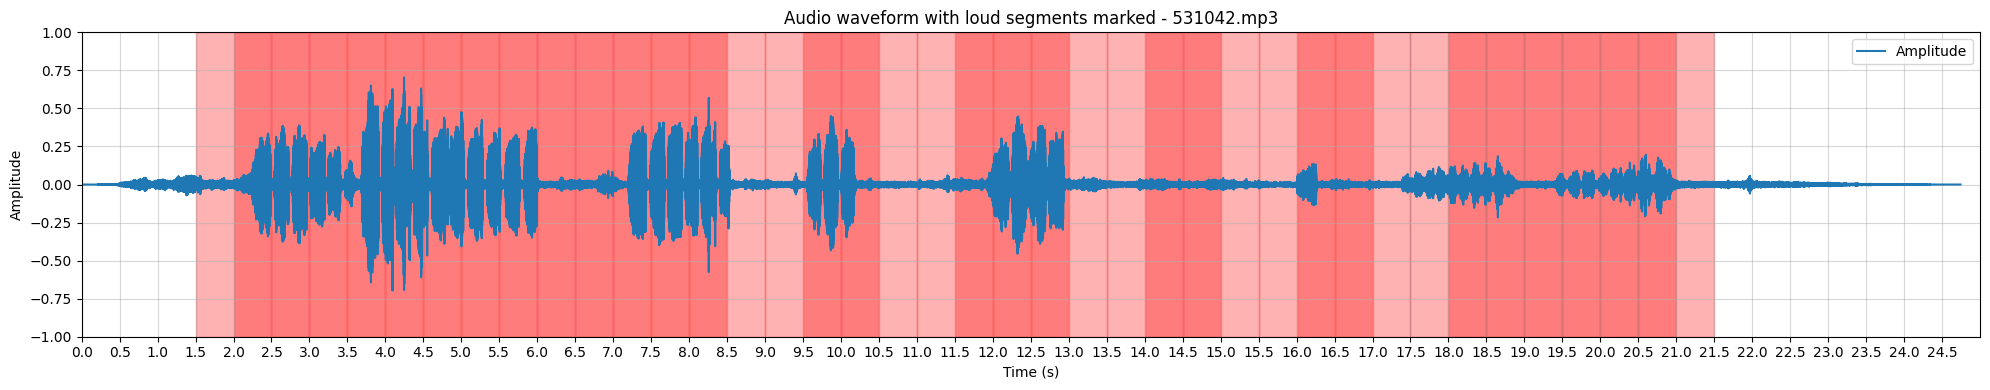

56335.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0]]


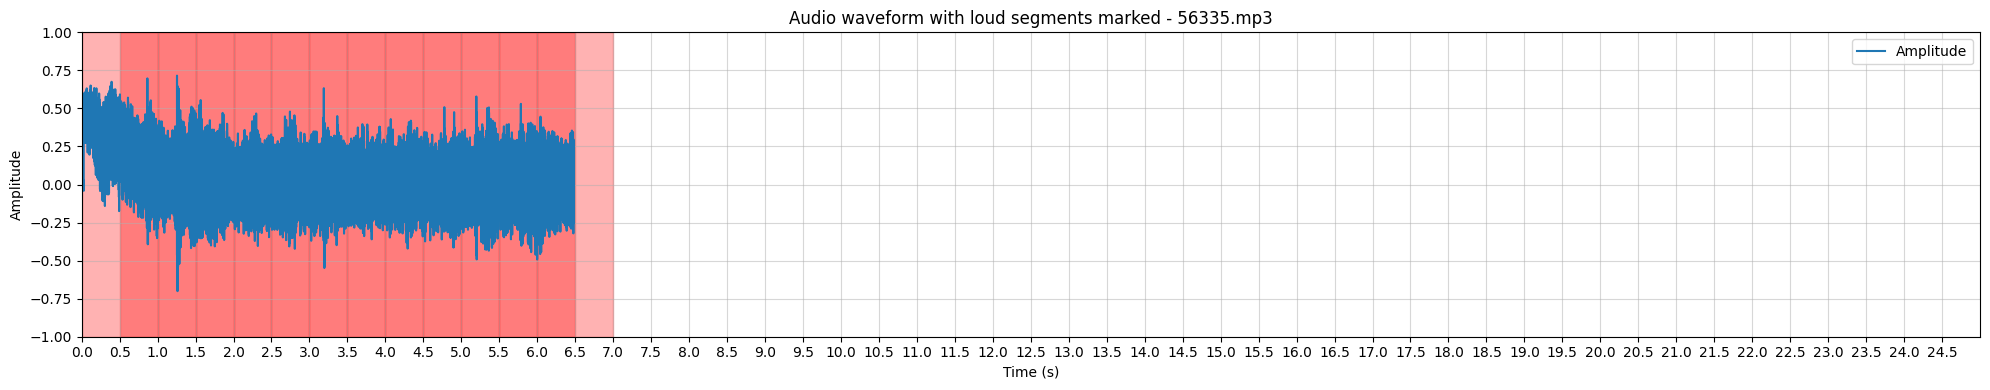

619422.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0], [22.5, 23.5], [23.0, 24.0], [23.5, 24.5], [24.0, 25.0], [24.5, 25.5], [25.0, 26.0], [25.5, 26.5], [26.0, 27.0], [26.5, 27.5], [27.0, 28.0], [27.5, 28.5], [28.0, 29.0], [28.5, 29.5], [29.0, 30.0], [29.5, 30.5], [30.0, 31.0], [30.5, 31.5], [31.0, 32.0], [31.5, 32.5], [32.0, 33.0], [32.5, 33.5], [33.0, 34.0], [33.5, 34.5], [34.0, 35.0], [34.5, 35.5], [35.0, 36.0], [35.5, 36.5], [36.0, 37.0], [36

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


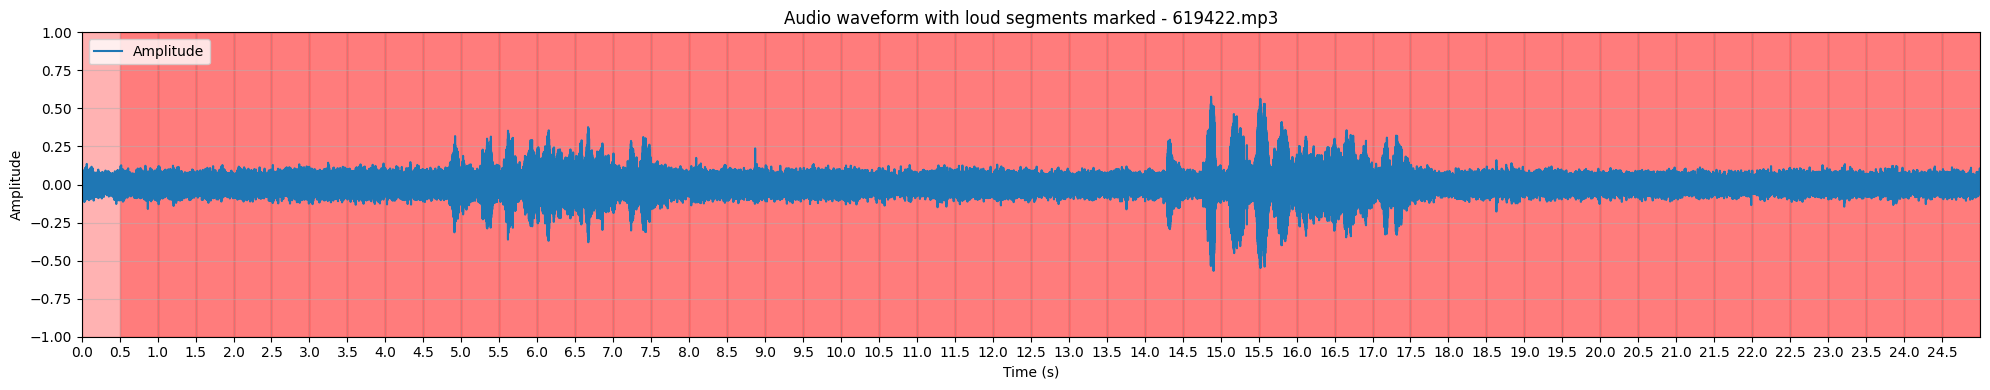

621138.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5]]


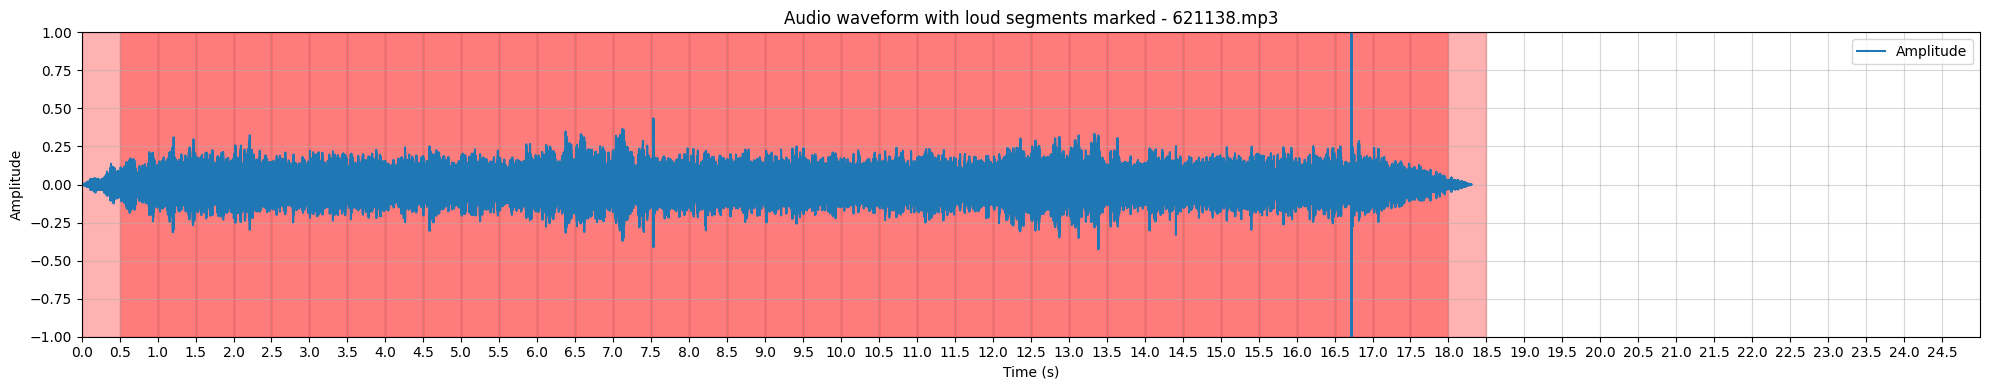

730938.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0]]


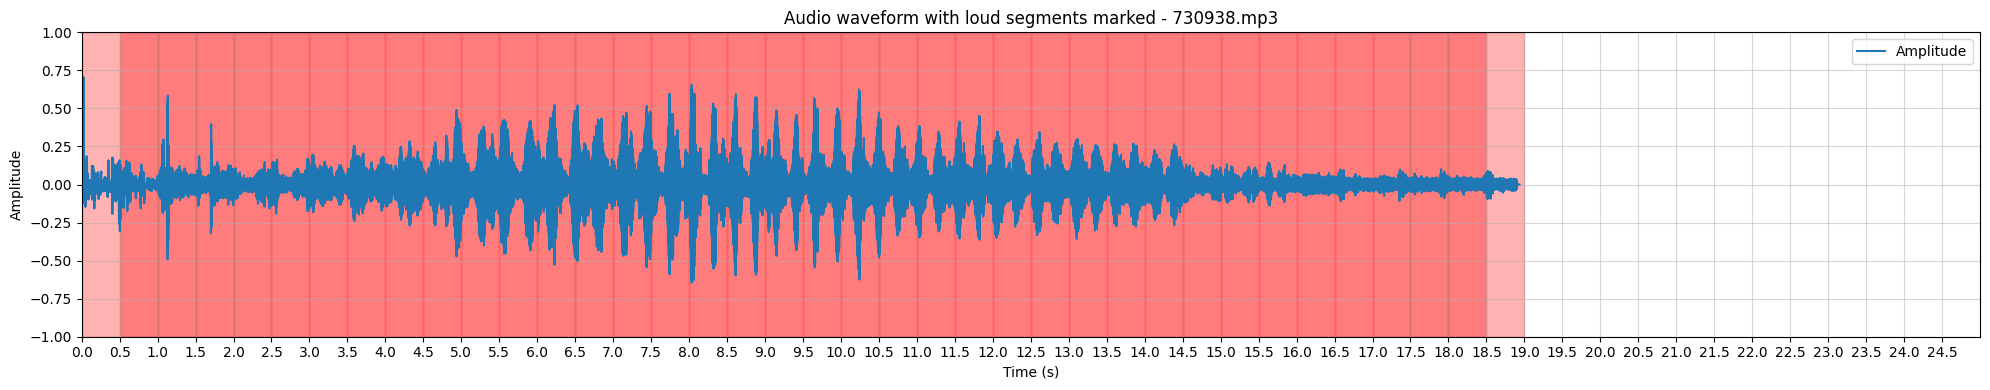

797339.mp3, [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [16.5, 17.5]]


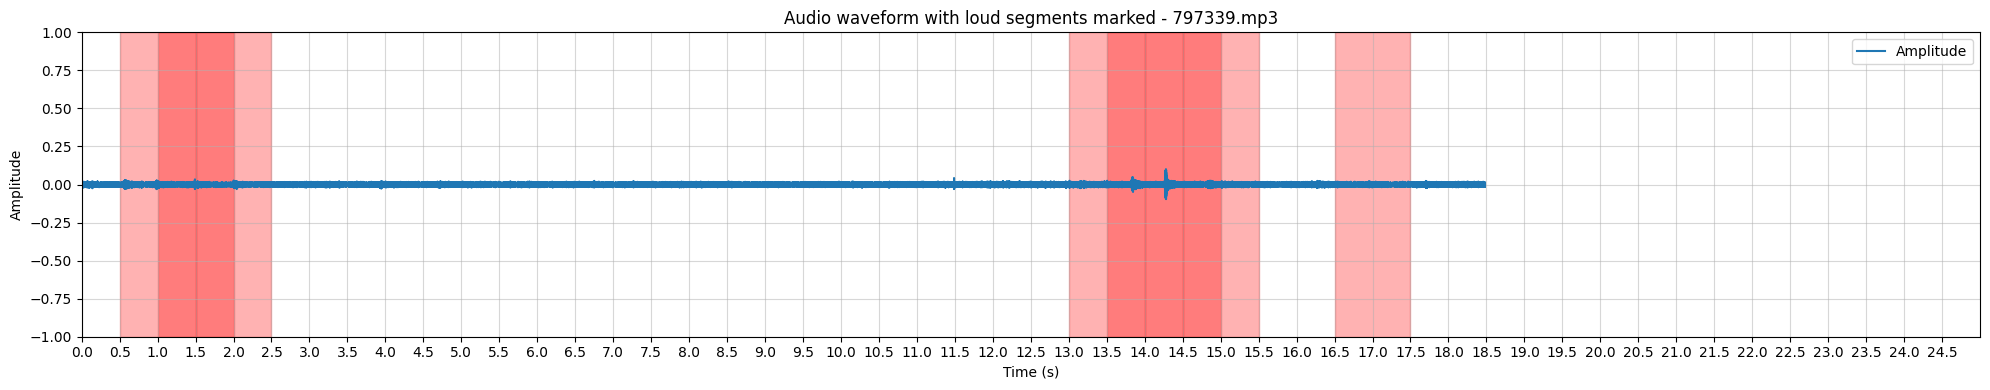

807858.mp3, [[3.5, 4.5], [4.0, 5.0], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5]]


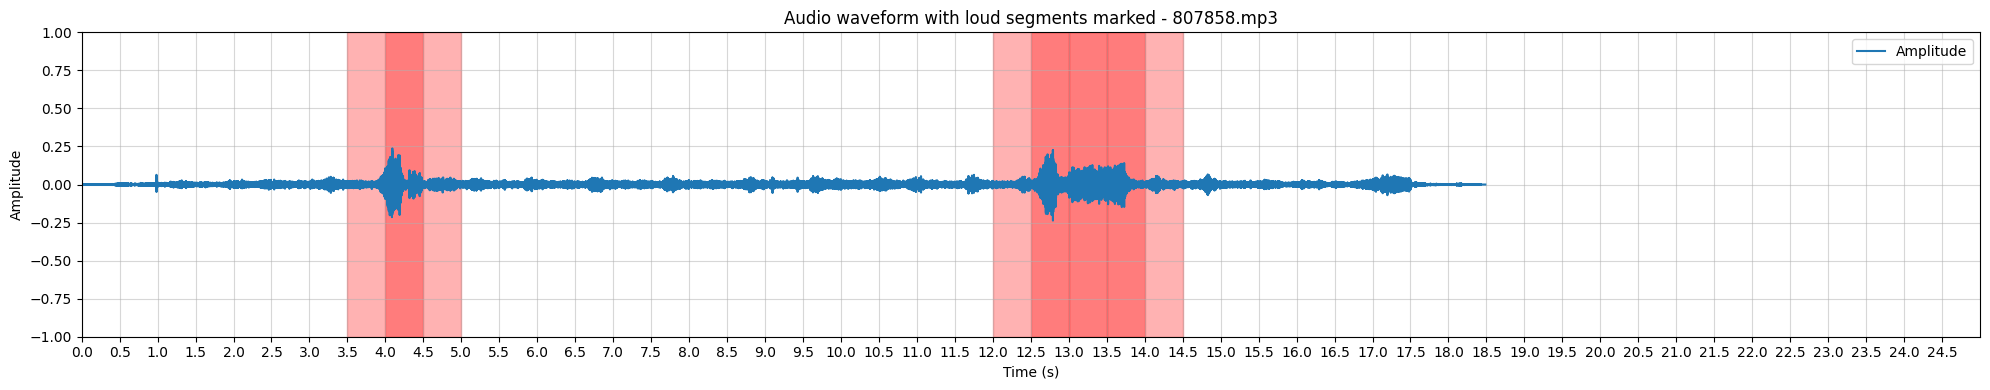

858981.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0]]


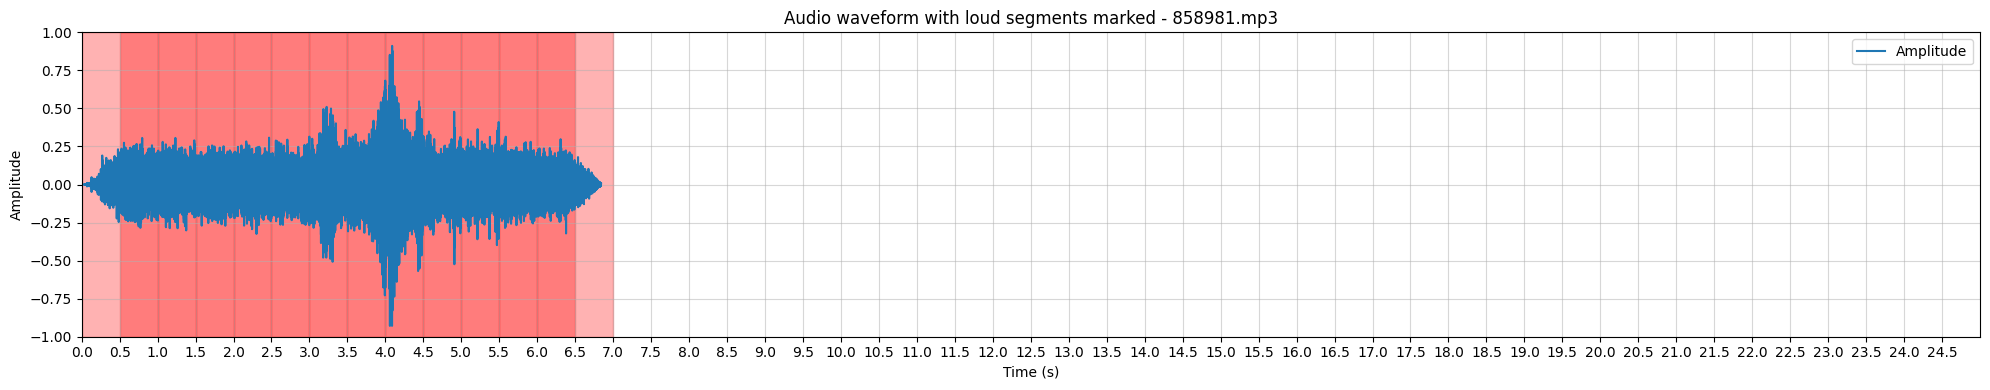

884691.mp3, [[0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [4.5, 5.5], [5.0, 6.0], [5.5, 6.5], [6.0, 7.0], [6.5, 7.5], [7.0, 8.0], [7.5, 8.5], [8.0, 9.0], [8.5, 9.5], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.0, 15.0], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0]]


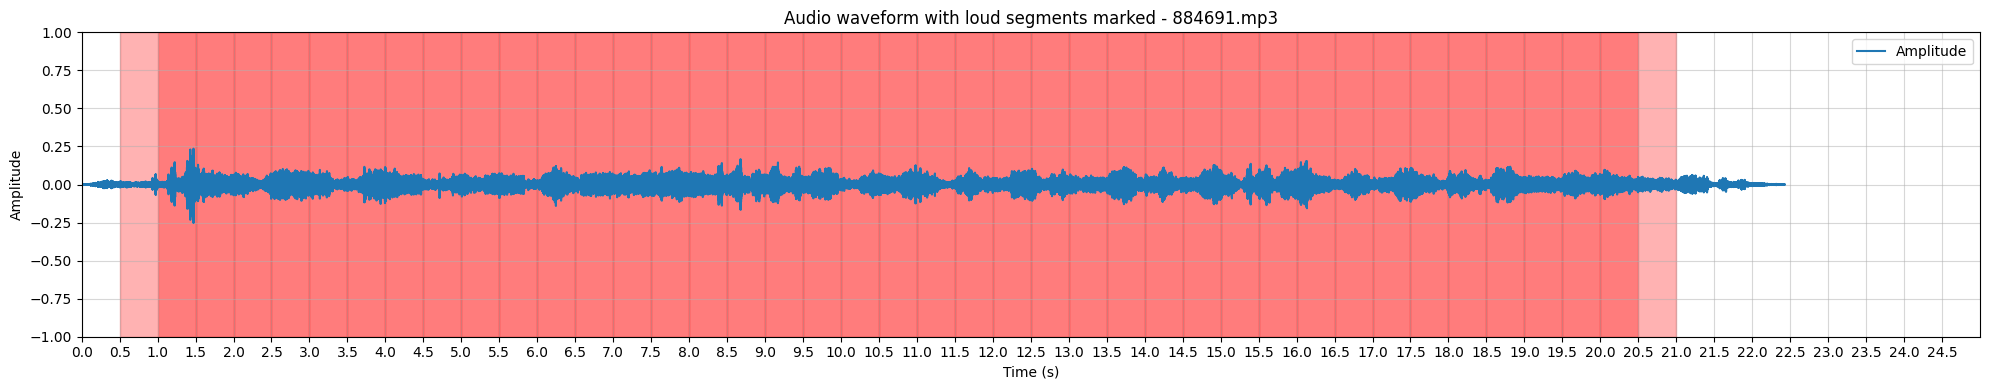

90765.mp3, [[0.0, 1.0], [0.5, 1.5], [1.0, 2.0], [1.5, 2.5], [2.0, 3.0], [2.5, 3.5], [3.0, 4.0], [3.5, 4.5], [4.0, 5.0], [9.0, 10.0], [9.5, 10.5], [10.0, 11.0], [10.5, 11.5], [11.0, 12.0], [11.5, 12.5], [12.0, 13.0], [12.5, 13.5], [13.0, 14.0], [13.5, 14.5], [14.5, 15.5], [15.0, 16.0], [15.5, 16.5], [16.0, 17.0], [16.5, 17.5], [17.0, 18.0], [17.5, 18.5], [18.0, 19.0], [18.5, 19.5], [19.0, 20.0], [19.5, 20.5], [20.0, 21.0], [20.5, 21.5], [21.0, 22.0], [21.5, 22.5], [22.0, 23.0], [22.5, 23.5], [23.0, 24.0], [25.5, 26.5], [26.0, 27.0], [26.5, 27.5], [27.0, 28.0], [27.5, 28.5], [28.0, 29.0], [28.5, 29.5], [29.0, 30.0], [29.5, 30.5], [30.0, 31.0], [30.5, 31.5], [31.0, 32.0], [31.5, 32.5], [32.0, 33.0], [32.5, 33.5], [33.0, 34.0], [33.5, 34.5], [34.0, 35.0], [34.5, 35.5], [35.0, 36.0], [35.5, 36.5], [36.0, 37.0], [36.5, 37.5], [37.0, 38.0], [37.5, 38.5], [38.0, 39.0], [38.5, 39.5], [39.0, 40.0], [39.5, 40.5], [40.0, 41.0], [40.5, 41.5], [41.0, 42.0], [41.5, 42.5], [42.0, 43.0], [42.5, 43.5], 

KeyboardInterrupt: 

In [ ]:
folder = f"{MAIN_PATH}/Dataset/xeno-canto"
for file in os.listdir(folder):
    path = f"{folder}/{file}"
    result = main_pipeline(path)
    list_label = [data["timestamp"] for data in result if data["label"] == 1]
    print(f"{file}, {list_label}")
    load_and_plot(path, list_label, 25)